# Updated Goos-Hanchen experiment
***

This notebook is a refactored version of the data reduction and analysis used during the actual experiment.

***
### Sample information
The two identical samples (assuming natural abundances) consist of the following layers with scattering length densities (SLDs) given in units of 10^-6 A^-2:
1. 50 nm Ti, SLD = -1.910
2. 50 nm Fe-Co-V 50-48-2%:
   1. Nuclear: SLD = 5.121
   2. Magnetic: SLD = -5.451 and 5.409
   3. Total: SLD = -0.33 and 10.53
4. 50 nm Si, SLD = 2.073
5. 50 nm Fe-Co-V 50-48-2%
6. 100 nm Ni-Mo 88-12% (non-magnetic), SLD = 8.52
7. Si substrate (total size 100 mm x 50 mm x 0.78 mm)

Non-magnetic blanks:
1. 100 nm Ni-Mo 88-12%
2. Si substrate (total size 100 mm x 50 mm x 0.78 mm)

## Functions and constants

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
from scipy.interpolate import CubicSpline,make_smoothing_spline
from scipy.optimize import curve_fit
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import scienceplots
import csv
import warnings
from os.path import isdir,isfile

plot_width = 10
plot_height = plot_width/2
fs = (plot_width,plot_height)
fs_double = (plot_width,1.75*plot_height)

plt.style.use(['science','notebook', 'grid','default','bright'])

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 16,18,20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size

default_plot_parms = {'size':fs,'title':[None],'xlabel':[None],'ylabel':[None],\
                      'grid':True,'figs':(1,1),'suptitle':None,'repeat':True}

def prepare_plot(other_parms={}):
    '''Helper function that returns basic figure object.'''
    parms = default_plot_parms|other_parms
    fig,axs = plt.subplots(*parms['figs'],figsize=parms['size'])
    fig_num = int(parms['figs'][0]*parms['figs'][1])
    plt.suptitle(parms['suptitle'])
    if fig_num == 1: axs = [axs]  #cleaning output of subplots
    if parms['repeat']:
        parms['title'] = parms['title']*fig_num
        parms['xlabel'] = parms['xlabel']*fig_num
        parms['ylabel'] = parms['ylabel']*fig_num
    for indx,ax in enumerate(axs):
        ax.set(title=parms['title'][indx],xlabel=parms['xlabel'][indx],ylabel=parms['ylabel'][indx])
        ax.grid(parms['grid'])
    return fig,axs

## Analytic calculations

In [ ]:
def get_su2_state(theta=0,phi=0,alpha=None,beta=None,gamma=0):
    '''Returns spin state, either with the usual parameterization or two complex numbers.'''
    if alpha is None or beta is None:
        result = [sym.cos(theta/2),sym.sin(theta/2)*sym.exp(sym.I*phi)]
    else:
        norm = sym.sqrt(sym.abs(alpha)**2 + sym.abs(beta)**2)
        result = 1/norm*[alpha,beta]
    return sym.exp(sym.I*gamma)*sym.Matrix(result).applyfunc(sym.simplify)

def get_op(a=0,b=0,c=0,d=0):
    '''Returns general operator in terms of the pauli vector.'''
    result = a*sym.eye(2) + b*sym.Matrix([[0,1],[1,0]]) + \
    c*sym.Matrix([[0,-sym.I],[sym.I,0]]) + d*sym.Matrix([[1,0],[0,-1]])
    return result.applyfunc(sym.simplify)

def get_proj(op,sign=1):
    '''Returns up/down projection operator.'''
    assert sign == -1 or sign == 1, 'The sign must be +/-1.'
    return (sym.Rational(1,2)*(sym.eye(2) + sign*op)).applyfunc(sym.simplify)

def expect(lstate,op,rstate=None,force_real=True):
    '''Returns the expectation value from the given state and operator.'''
    if rstate is None: rstate = lstate
    result = (lstate.H*op*rstate)[0]
    if force_real: result = sym.re(result)
    return result.simplify()

def change_basis(op,new):
    '''Returns operator in new basis.'''
    return (new.inv()*op*new).applyfunc(sym.simplify)

def time_av(func,var,N=1):
    '''Returns time average over N periods'''
    integral = func.integrate((var,-sym.pi*N,sym.pi*N))
    return (integral/(2*sym.pi*N)).expand().simplify()

p0,p1,p2,t1,t2,P1,P2,P = sym.symbols(r'\phi_0,\phi_1,\phi_2,\theta_1,\theta_2,\Phi_1,\Phi_2,\Phi',real=True)
idt,spx,spy,spz = get_op(a=1),get_op(b=1),get_op(c=1),get_op(d=1)

#asummes the magnetization is along the x-direction and incident polarization is along z
x_cob = 1/sym.sqrt(2)*sym.Matrix([[1,1],[1,-1]])
interaction = change_basis(sym.diag(1,sym.exp(sym.I*P)),x_cob)
print('Interaction matrix:')
display(interaction.applyfunc(sym.simplify))

In [ ]:
print('Evolution of the spin states:')
psi0 = get_su2_state(theta=sym.pi/2,phi=0)  #phi_0=0 for incident polarization along x-direction
display('Initial state:',psi0)
psi1 = get_op(a=(1+sym.exp(sym.I*t1))/2,d=(1-sym.exp(sym.I*t1))/2)*psi0
display('First arm:',psi1)
psi2 = interaction*psi1
display('After interaction:',psi2)
psi3 = get_op(a=(1+sym.exp(-sym.I*t2))/2,d=(1-sym.exp(-sym.I*t2))/2)*psi2
display('Second arm:',psi3)

In [ ]:
Pols = []
print('Final polarization components')
for i,k in zip(['Px','Py','Pz'],[spx,spy,spz]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols.append(pk)  #saving this value
    print('At echo, theta_1 = theta_2')
    pk = pk.subs(t2,t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

In [ ]:
Pols2 = []
print('Final polarization components')
for i,k in zip(['P_+x','P_-x','P_x'],[get_proj(spx,sign=1),get_proj(spx,sign=-1),spx]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols2.append(pk)  #saving this value
    print('When theta_1 = -theta_2')
    pk = pk.subs(t2,-t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

In [ ]:
nm,theta,phi,gam = sym.symbols(r'n_m,\theta,\phi,\gamma',real=True)  #general interaction matrix calculation
c1,c2 = get_su2_state(theta=theta,phi=phi,gamma=gam),\
        get_su2_state(theta=sym.pi-theta,phi=phi+sym.pi,gamma=-gam)
gen_basis = sym.Matrix(np.hstack([c1,c2]))
display(gen_basis)
display(gen_basis := gen_basis.subs(((theta,sym.pi/2),(phi,sym.pi/2),(gam,sym.pi/4))))

gen_mag = change_basis(spz,gen_basis).applyfunc(sym.simplify)
display(gen_mag)

#display(gen_mag)

## Numerical reflectivity calculations

This section needs some work, right now it doesn't agree with what Victor and Roger calculated.

In [ ]:
LAMS = np.linspace(2.5,13.5,300)  #nominal wavelength range on Larmor

def get_crit(SLD,lam=LAMS,degrees=True):
    '''Returns critical angle.'''
    result = np.arcsin(lam*np.sqrt(SLD*10**-6/np.pi))
    if degrees: result *= 180/np.pi
    return result

def get_pot(SLDs=[],ts=[],plot=False,plot_parms=SLD_PLOT_PARMS):
    '''Returns the potential given the thicknesses and SLDs of each layer.
    Doesn't include substrate.'''
    total_x = np.linspace(0,np.sum(ts),500)
    steps = np.array([np.sum(ts[:i]) for i in range(len(ts)+1)])
    potential = np.sum([SLDs[indx]*((steps[indx]<=total_x)&(total_x<=steps[indx+1])) for indx in range(len(SLDs))],axis=0)
    if plot: plot_function([total_x],[potential],plot_parms)
    return potential,total_x

SLDs = {'Ti':-1.910,'FeCoV_nuc':5.121,'FeCoV_up':-0.33,'FeCoV_down':10.53,'Si':2.06,'NiMo':8.52,\
       'exp_FeCoV_up':0.26961,'exp_FeCoV_down':9.93501}
sample_ts = np.array([50.,50.,50.,50.,100.])*10  #convert to Angstroms
blank_ts = np.array([100.])*10

sample_nuc_SLDs = [SLDs['Ti'],SLDs['FeCoV_nuc'],SLDs['Si'],SLDs['FeCoV_nuc'],SLDs['NiMo']]
sample_up_SLDs = [SLDs['Ti'],SLDs['FeCoV_up'],SLDs['Si'],SLDs['FeCoV_up'],SLDs['NiMo']]
sample_down_SLDs = [SLDs['Ti'],SLDs['FeCoV_down'],SLDs['Si'],SLDs['FeCoV_down'],SLDs['NiMo']]
blank_SLDs = [SLDs['NiMo']]

sample_tc = get_crit(sample_nuc_SLDs[1]),get_crit(sample_up_SLDs[2]),get_crit(sample_down_SLDs[1])
blank_tc = get_crit(blank_SLDs[0])
plot_function([LAMS for i in range(4)],[*sample_tc,blank_tc],plot_parms=THETA_C_PARMS)

sample_nuc,X = get_pot(sample_nuc_SLDs,ts=sample_ts,\
                       plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('nuc','up','down')})
sample_up,_ = get_pot(sample_up_SLDs,ts=sample_ts,\
                      plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up')})
sample_down,_ = get_pot(sample_down_SLDs,ts=sample_ts,\
                        plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('down')})
blank,Xb = get_pot(blank_SLDs,ts=blank_ts,\
                   plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('blank')})

plot_function([X,X,X,Xb],[sample_nuc,sample_up,sample_down,blank],\
              plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('nuc','up','down','blank')})

In [ ]:
sample_up_SLDs = [SLDs['Ti'],SLDs['exp_FeCoV_up'],SLDs['Si'],SLDs['exp_FeCoV_up'],SLDs['NiMo']]
sample_down_SLDs = [SLDs['Ti'],SLDs['exp_FeCoV_down'],SLDs['Si'],SLDs['exp_FeCoV_down'],SLDs['NiMo']]

sample_up,_ = get_pot(sample_up_SLDs,ts=sample_ts,\
                      plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up')})
sample_down,_ = get_pot(sample_down_SLDs,ts=sample_ts,\
                        plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('down')})
plot_function([X,X],[sample_up,sample_down],\
              plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up','down')})

In [ ]:
def get_t_matrix(SLDs,ts,k0=.314,substrate=SLDs['Si']):
    '''Given a potential, returns the transfer matrix. Assumes air for z<=0 and 
    an additional infinite-thickness substrate layer.'''
    assert len(SLDs) == len(ts), 'Check number of layers!'
    km = [np.emath.sqrt(k0**2 - 4*np.pi*rho*1e-6) for rho in [0.]+SLDs+[substrate]]
    ms = len(km)  #air 0, layers (1,...,N), substrate N+1
    
    phim = [0]+[km[i]*ts[i] for i in range(ms-2)]  #phi_0 special case
    
    tm = [2*km[i]/(km[i] + km[i+1]) for i in range(ms-1)]
    rm = [(km[i] - km[i+1])/(km[i] + km[i+1]) for i in range(ms-1)]

    Rm = [np.array([[1,rm[i]],[rm[i],1]]) for i in range(ms-1)]
    Cm = [1/tm[i]*np.diag((np.exp(-1j*phim[i]),np.exp(1j*phim[i])))@Rm[i] for i in range(ms-1)]

    t_matrix = np.identity(2)
    for C in Cm:
        t_matrix = np.matmul(t_matrix,C)
    return t_matrix

def get_R_Phi(t_up,t_down=None):
    '''Calculates reflectivity (R) and phase (Phi) from t-matrix entries.'''
    R_up = np.abs(t_up[:,1,0])**2/np.abs(t_up[:,0,0])**2
    result = [R_up]
    if t_down is not None:
        R_down = np.abs(t_down[:,1,0])**2/np.abs(t_down[:,0,0])**2
        result.append(R_down)
        result.append(np.angle(t_up[:,1,0]/t_up[:,0,0]) - np.angle(t_down[:,1,0]/t_down[:,0,0]))
    return result

theta = .35*np.pi/180  #scattering angle
wavelengths = np.linspace(2,13.5,1000)

t_up = np.array([get_t_matrix(sample_up_SLDs,sample_ts,k0=2*np.pi*theta/w) for w in wavelengths])
t_down = np.array([get_t_matrix(sample_down_SLDs,sample_ts,k0=2*np.pi*theta/w) for w in wavelengths])
R_up,R_down,phase = get_R_Phi(t_up,t_down)

plt.figure(figsize=(10,5))
plt.plot(wavelengths,np.cos(phase),'-',label='Pol',lw=2,color='C0')
plt.plot(wavelengths,R_up,'--',label='$R_{up}$',lw=2,color='C1')
plt.plot(wavelengths,R_down,'--',label='$R_{down}$',lw=2,color='C2')
#plt.plot(wavelengths,R_nuc,'--',label='$R_{nuc}$',lw=2,color='C1')
#plt.plot(wavelengths,R_blank,'--',label='$R_{blank}$',lw=2,color='C2')
plt.xlabel(r'$\lambda$ (AA)')
plt.ylim(-1.05,1.05)
plt.legend()
plt.grid()
plt.show()

'''GH_shift = wavelengths[1:]**2*np.cos(theta*np.pi/180)*np.diff(phase)/(2*np.pi)
plt.figure(figsize=(10,5))
plt.plot(wavelengths,phase,'--',label=r'$\Phi$',lw=2,color='C0')
plt.plot(wavelengths[1:],GH_shift,'-',label='GH-shift',lw=2,color='C1')
plt.xlabel(r'$\lambda$ (AA)')
plt.legend()
plt.grid()
plt.show()'''

## Experiment log
***

### 11/14 Day One (Tuesday)
Setup and calibration of the beamline.

* 9:30
* We decided that the magnetization of the sample will probably not be a problem because the sample is so thin. Therefore we will not worry about the mismatch of the sample field direction and the guide field direction.
* Still need to magnetize the sample today and finish the sample holder.

* 2:00
* Found the echo before lunch, need to finish building the sample holder and check the echo as we scan the sample stage (should only need a few mm of drive)
* Should we use a supermirror or a blank for tuning echo? (decided to just use blank)
* Aligning the sample slit with the transmission monitor

* 7:00
* Decided to run echo scans overnight to test the long-term stability of the echo point because we cannot retune the echo once we put the magnetic sample in the beam. Also included a scan of the sample stack translation.

### 11/15 Day Two (Wednesday)
Mounting the blank with NO longitudinal splitting. (and the sample)

* 10:30
* Echo stability was very stable overnight for all positions of the sample stack. Above 80% for 3-10 AA.
* Leveled the sample stack (+/- 0.1 degrees for both directions)
* Adjusted the sample center of rotation to be the same center of rotation of the second arm (within few cms).
* Finding the center of the beam using a piece of Cd taped to the Al sample holder
* By eye using laser, the center is at 27 mm and 58.25 degrees
* Laser beam and neutron beam are off by 0.4 mm using the monitor right after the sample position (center 26.6 mm using neutrons, add 0.8 mm to include the thickness of the sample)
* Increasing the beam height did not change the tune (25 mm at the front, 40 mm at the sample)
* Collimation from pipe 31 mm
* Snout aperture 30 mm height 30 mm width (yes, it is that wide)
  

* 11:00
* Pixel 34 is the center of the beam at the moment (0.64 mm per pixel)
* 41004,41005 are the spectra numbers
  

* 1:00
* Magnetized the sample, wrote the field direction on the Al plate. Went to above 0.027 Tesla
* Found the critical edge to be at 0.35 degrees (aiming for 0.4 degrees?)

* 3:00
* The blank appears to be curved? The beam is spread over 8 pixels instead of 4 as before.

* 5:00
* Aperture width is still 2 mm wide
* Magnetic sample agrees well with Victor's model assuming 89% magnetization. This value agrees more closely with the 
* Going to measure the magnetic sample overnight

### 11/16 Day Three (Thursday)

* 10:00
* Magnetic sample ran successfully overnight. Improving statistics on the blank until after lunch.

* 8:00
* Magnetic sample rotated by 90 degrees replicated the original polarization except now the signal is cos(phi) instead of 1/2*(1 + cos(phi))
* Going to run this orientation overnight and add the grating in tomorrow

### 11/17 Day Four (Friday)

* 11:00
* Added the grating after the sample (GR27, 2 um period, 10.5 um depth, 560 nm groove width)
* Sample still in the vertical direction
* Doubled-checked where the instrument parameters are stored. They appear in the log book under "Analysis/Property/Run".
  * Pre-sample slit: 0.5 mm by 25 mm
  * Post sample slit: 2 mm by 25 mm

### 11/18 Day Five (Saturday)

* 10:00
* Running with grating before sample until 2:00 pm to compare with the sample only run
* After that, we'll get better statistics for the P0 run before changing the incident angle to shift the GH bump in the polarization to appear at shorter wavelengths
* The journal viewer title was wrong for some runs. The correct naming is
  * 79130 - 79142 No grating
  * 79143 - 79144 Grating after sample
  * 79145 - 79159 Grating before sample
  * 79160 - 79164 Grating after sample (again)

* 11:30
* Going to measure the broken samples with X-rays (don't know the roughness numbers)
* Got the fitting functon for P0 to work, need to port the q function as well
* The new data seems show that the grating was slightly tilted about the vertical axis or that the P0 has slightly decreased (more likely grating angle misalignment because peak heights are still tall)

### 11/19 Day Six (Sunday)

* 9:00
* Overnight data looks good. The peak shifted from ~8.5 A to 11 A as expected
* Running with grating before the sample, will run until 8 pm tonight, then put the grating after the sample to finish through the night.
* Results at 0.4 consistent with the old 0.35 degree data
* 0.40 degree data:
  * 79179 - 79188 No grating
  * 79189 - 79199 Grating before sample
  * 79200 - 79212 Grating after sample

## Data reduction and analysis
***

### Data loading and processing functions

In [37]:
data_paths = {'laptop':'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\\Reduced_data_correct_eb\\',
             'ceem':'C:\\Users\\samckay\\Documents\\GitHub\\Goos-Hanchen\\\Reduced_data_correct_eb\\',
             'home':'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\\Reduced_data_correct_eb\\'}

DEFAULT_PATH = data_paths['home']
assert isdir(DEFAULT_PATH), 'Default data directory was not found!'

def load_data_2D(file,path=DEFAULT_PATH,pix_trim=None):
    '''Loads the mantid output data into numpy 2D array.
    Returns X, Y, and E coordinate arrays, and pixel name.'''
    assert isdir(path), 'Data directory was not found!'
    assert isfile(path+file), 'Data file was not found!'
    with open(path+file) as f:
        lines = f.readlines()[1:]
        lines = [l.replace('\n','').split(',') for l in lines]
        pnames,xs,ys,es = [],[],[],[]  #pixel name from DAC
        for l in lines:
            if len(l) != 3: pnames.append(l[0])
            else:
                xs.append(float(l[0]))
                try:
                    ys.append(float(l[1]))
                    es.append(float(l[2]))
                except Exception:
                    ys.append(np.NaN)  #dumbass Mantid stuff
                    es.append(np.Inf)
        lnum,pnum = len(lines),len(pnames)  #tof pixels, spatial pixels
        new_shape = (len(pnames),(len(lines)-len(pnames))//len(pnames))
    result = [xs,ys,es]
    result = [np.array(r).reshape(new_shape) for r in result]
    pnames = np.array(pnames,dtype='int')
    if pix_trim is not None:
        result = [r[pix_trim,:] for r in result]
        pnames = (pnames - pnames[0])[pix_trim]
    return result,pnames  #pixel names (pnames) is inhomogenous part

def unnormalize(counts,errors):
    '''Returns raw counts and errors assuming Poisson statistics.'''
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
        errs = np.nan_to_num(counts/errors)
        result = errs**2
    return result,errs

def Q_conversion(lam,pixels,center,th0,pix_size=.65,dist=4350.):
    '''Returns conversion matrix of wavelength to momentum transfer.'''
    thQ = np.array([.5*np.arctan((p - center)/dist*pix_size) for p in pixels])
    Q = np.array([4*np.pi/lam*np.sin(th0*np.pi/180. - thq) for thq in thQ])
    return np.flip(Q,axis=1)

def do_rebin(data,new_bins):
    '''Rebins interpolated data for constant q so each pixel has the same binning.'''
    temp = np.full(len(data),np.NaN)
    for old,new in enumerate(new_bins):
        temp[new] = data[old]
    return temp

def trim_arr(arrays,segments):
    '''Applies the same trim to a list of arrays. First array determines
    the trimming for the other arrays.'''
    result = []
    masks = np.array([(s[0]<arrays[0]) & (arrays[0]<s[1]) for s in segments])

    if masks[0].ndim == 1: new_pix_nums = int(np.sum(masks[0]))
    else: new_pix_nums = masks[0].shape[0],np.sum(masks[0],axis=1)[0] #number of new vertical and horizontal pixels
    for a in arrays:
        for m in masks:
            a = a[m]
        result.append(a)
    return [r.reshape(new_pix_nums) for r in result]  #assumes unpacking

def get_constant_Q(data,errs,lam,pixels,center,th0,q_bins=200,spln=CubicSpline,trim=[4.,12.]):
    '''Returns 2D counts rebinned with constant momentum transfer Q.
    Trims wavelength range to the center pixel range.'''
    Q = Q_conversion(lam,pixels,center,th0)
    data_Q = np.flip(data,axis=1)  #need to flip for spline
    errs_Q = np.flip(errs,axis=1)
    q_spaces = [np.linspace(q[0],q[-1],q_bins) for q in Q]
    data_intrp = [spln(q,p)(qs) for q,p,qs in zip(Q,data_Q,q_spaces)]
    err_intrp = [spln(q,e)(qs) for q,e,qs in zip(Q,errs_Q,q_spaces)]

    q_tot = np.linspace(np.min(Q),np.max(Q),q_bins)
    new_bins = np.digitize(q_spaces,q_tot,right=True)
    const_q = np.array([do_rebin(p,nb) for p,nb in zip(data_intrp,new_bins)])
    const_q_errs = np.array([do_rebin(e,nb) for e,nb in zip(err_intrp,new_bins)])
    
    lam_const_q = 4*np.pi/q_tot*np.sin(th0*np.pi/180)  #convert to wavelength
    lam_bins = np.linspace(np.min(lam_const_q),np.max(lam_const_q),q_bins)
    second_intrp = np.array([spln(np.flip(lam_const_q),p)(lam_bins) for p in np.flip(np.nan_to_num(const_q),axis=1)])
    second_intrp_errs = np.array([spln(np.flip(lam_const_q),e)(lam_bins) for e in np.flip(np.nan_to_num(const_q_errs),axis=1)])

    second_intrp = np.where(second_intrp>0,second_intrp,0.)
    second_intrp_errs = np.where(second_intrp_errs>0,second_intrp_errs,0.)

    if trim is not None:
        temp,second_intrp,second_intrp_errs = trim_arr((np.stack([lam_bins]*len(pixels)),second_intrp,second_intrp_errs),[trim])
        lam_bins = temp[0]
    
    return lam_bins,second_intrp,second_intrp_errs

def get_center(up,down,pname,threshold=.05,show=True):
    '''Returns the center pixel of the given data (assumed to be from blank).
    The pixel number is the weight for the average.'''
    sum1,sum2 = np.nansum(up,axis=1),np.nansum(down,axis=1)
    sum = sum1 + sum2
    c1,c2 = np.average(pname,weights=sum1),np.average(pname,weights=sum2)
    center = int(round(np.mean([c1,c2])))
    pixels = pname[np.where(sum>np.max(sum)*threshold)]
    pixels = np.append(pixels,pixels[-1]+1)
    
    if show:
        print('Center pixel:')
        print(f'[up,down]: {np.round([c1,c2],5)} -> {center}')
        print('Pixels used:')
        print(pixels[:-1],f': {len(pixels[:-1])} total.')

        plot_parms = {'title':[None],'xlabel':['pixel'],'ylabel':['counts']}
        fig,axs = prepare_plot(plot_parms)
        axs[0].plot(pname,sum1,'o-')
        axs[0].plot(pname,sum2,'o-')
        axs[0].plot(pname,sum,'o-',label='shim')
        axs[0].axvline(x=center,ls='--',color='blue')
        axs[0].axvline(x=pixels[0],ls='--',color='red')
        axs[0].axvline(x=pixels[-1]-1,ls='--',color='red')
        plt.legend()
        plt.show()
        
    return center,pixels  #assumed that rightmost point is NOT included

def get_pol_shim(up,down,up_err,dn_err,pname,trim=None):
    '''Returns the polarization and shim intensity with errors.'''
    assert np.shape(up) == np.shape(down),'Up and down counts must have equal shapes!'
    if trim is not None:
        mask = [True if i in trim else False for i in pname]
        up,down,up_err,dn_err = [k[mask,:] for k in [up,down,up_err,dn_err]]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  #ignores nan mulitply and zero divide warnings
        shim = up + down
        shim_errs = np.sqrt(up_err**2 + dn_err**2)
        pol = -(up - down)/shim
        pol_errs = np.sqrt((dn_err*(pol + 1))**2 + (up_err*(pol - 1)**2))/(2*shim)
        pixels = np.arange(len(up[:,0]))
        std_shim = np.array([np.sqrt(np.cov(pixels,aweights=lam)) for lam in shim.T])
    return shim,shim_errs,pol,pol_errs,std_shim

def load_data1D(file,path=DEFAULT_PATH):
    '''Legacy method! Loads 1D mantid data into numpy array.'''
    assert isdir(path), 'Data directory was not found!'
    assert isfile(path+file), 'Data file was not found!'
    with open(path+file) as f:
        temp = f.readlines()[2:-2]
        temp = [l.replace('\n','').split(',') for l in temp]
        x = np.array([float(temp[x][0]) for x in range(len(temp))])
        y = np.array([float(temp[y][1]) for y in range(len(temp))])
        e = np.array([float(temp[y][2]) for y in range(len(temp))])
    return x,y,e

### Blank NiMo sample reduction
***

##### Comparing the beam profiles from the 3 data sets:

- The first data set is for the "blank sample" (typically labeled b throughout this notebook) with long edge perpendicular to the guide field. The second two data sets are the "parallel" configuration with long edge parallel to the guide field direction.
- There is a significant difference between the the beam size and center for all three data sets, which is to be expected as we had to take the sample off of the mount each time. Unfortunately, this means that there is no way to "find unity" when we try to normalize the sample shims by the blank shims.

In [20]:
pixs = np.arange(27,42)  #rough detector pixel trimming
(lam_b_perp,up_b_perp,eup_b_perp),pname_b_perp = load_data_2D(r"blank_perp\\up.txt",pix_trim=pixs)
(_,dn_b_perp,edn_b_perp),_ = load_data_2D(r"blank_perp\\dn.txt",pix_trim=pixs)
lam_b_perp = lam_b_perp[0]

(lam_b_para1,up_b_para1,eup_b_para1),pname_b_para1 = load_data_2D(r"blank_para1\\up.txt",pix_trim=pixs)
(_,dn_b_para1,edn_b_para1),_ = load_data_2D(r"blank_para1\\dn.txt",pix_trim=pixs)
lam_b_para1 = lam_b_para1[0]

(lam_b_para2,up_b_para2,eup_b_para2),pname_b_para2 = load_data_2D(r"blank_para2\\up.txt",pix_trim=pixs)
(_,dn_b_para2,edn_b_para2),_ = load_data_2D(r"blank_para2\\dn.txt",pix_trim=pixs)
lam_b_para2 = lam_b_para2[0]

(lam_b,up_b,eup_b),pname_b = load_data_2D(r"blank_all\\up.txt",pix_trim=pixs)
(_,dn_b,edn_b),_ = load_data_2D(r"blank_all\\dn.txt",pix_trim=pixs)
lam_b = lam_b[0]

##### Checking raw data and unnormalizing:

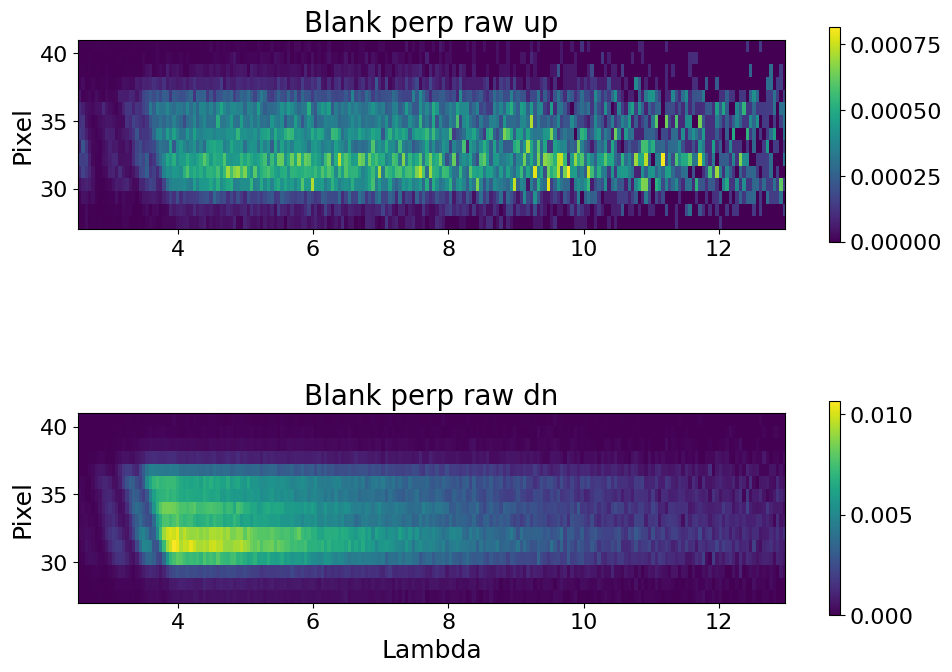

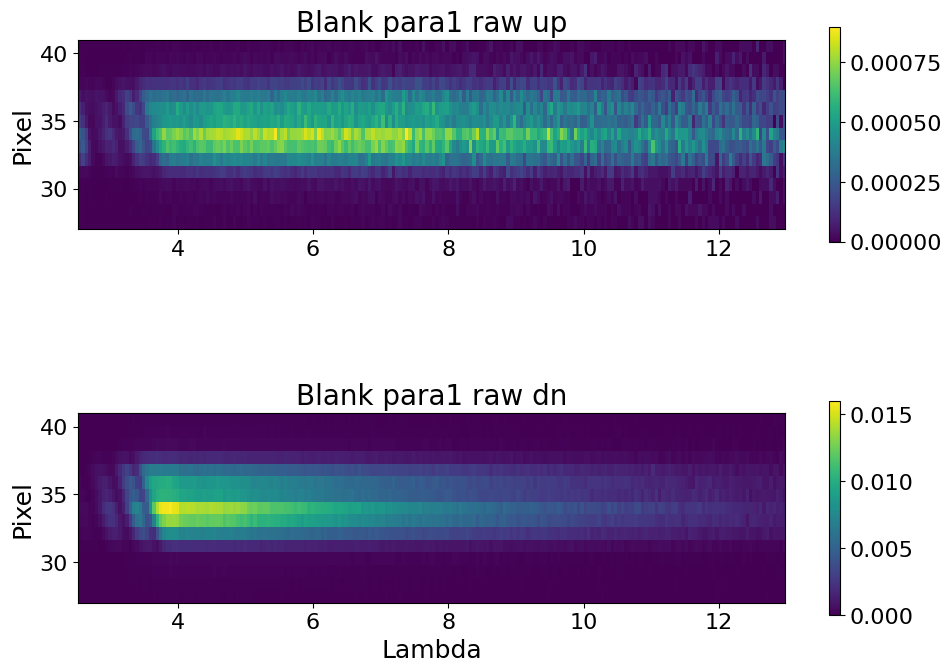

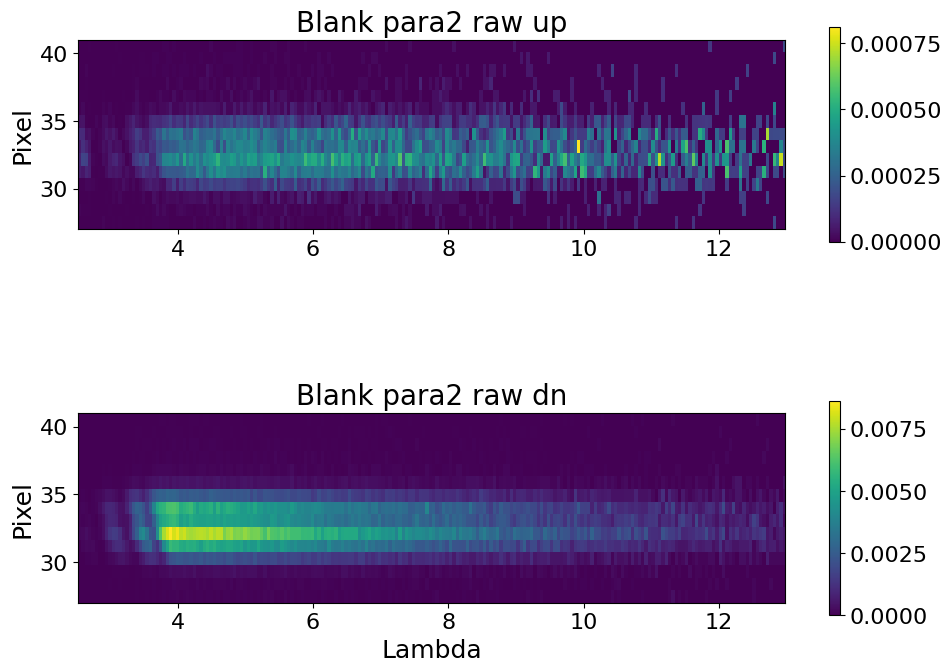

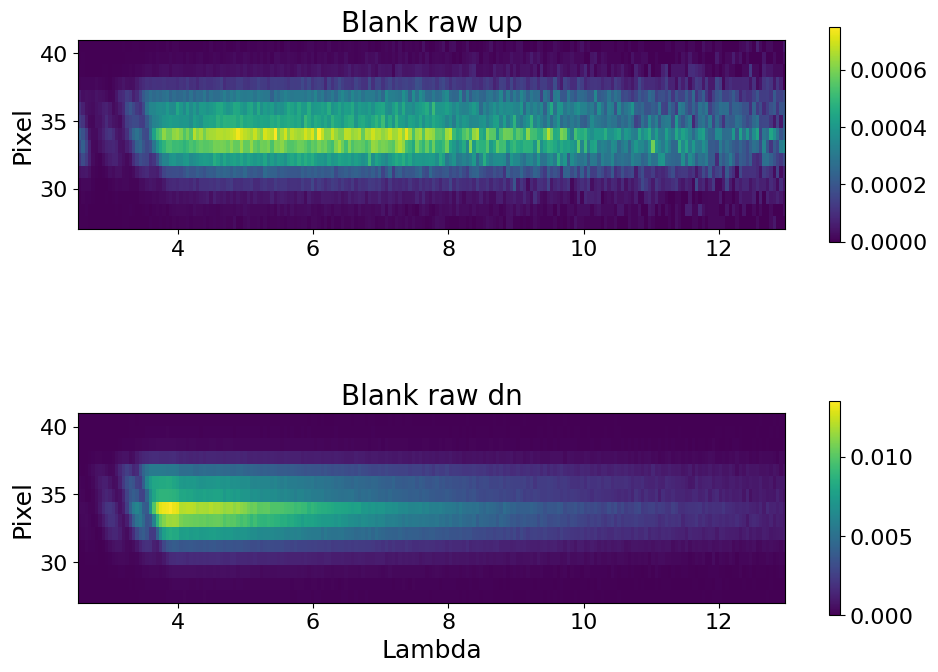

In [21]:
fig,axs = prepare_plot({'grid':False,'title':['Blank perp raw up','Blank perp raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b_perp,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b_perp,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank para1 raw up','Blank para1 raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b_para1,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b_para1,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank para2 raw up','Blank para2 raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b_para2,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b_para2,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank raw up','Blank raw dn'],\
                        'xlabel':[None,'Lambda'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_b,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_b,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

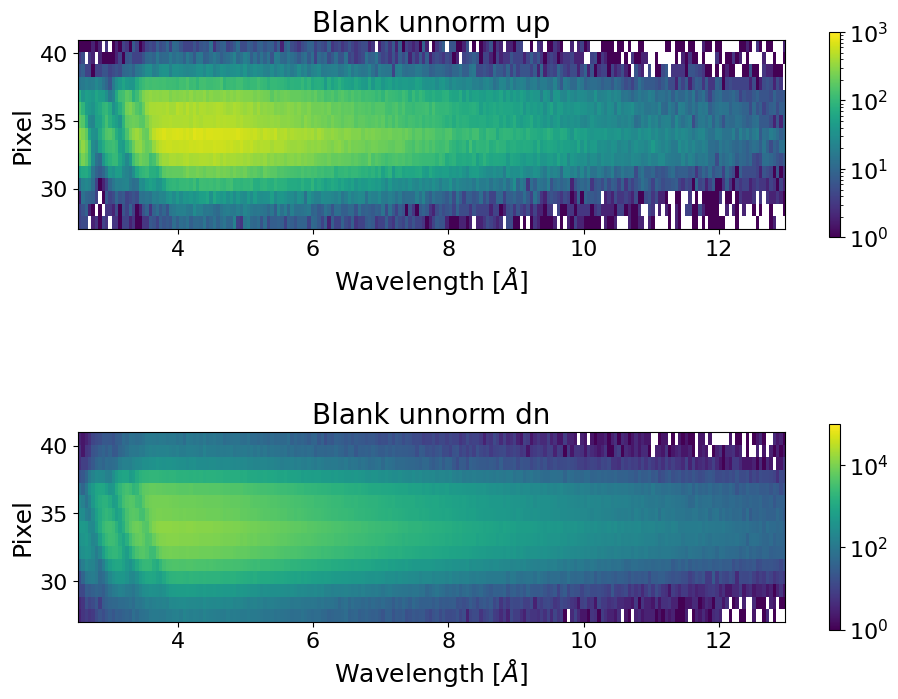

In [22]:
up_blank,up_errs_blank = unnormalize(up_b,eup_b)
dn_blank,dn_errs_blank = unnormalize(dn_b,edn_b)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_blank,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e3))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_blank,origin='lower',extent=(lam_b_perp[0],lam_b_perp[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

##### Correction for Q:

These cells interpolate the data first to get the neutron counts as a function of momentum transfer Q, then perform a second interpolation to plot the data as a function of pixel and wavelength. The counting errors are interpolated in the same way.

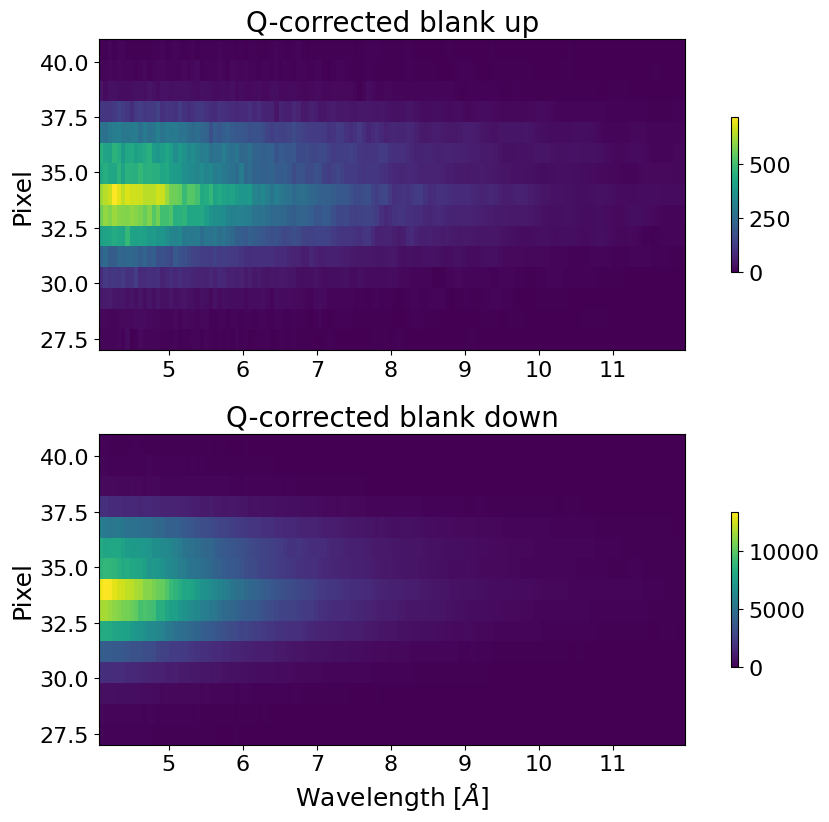

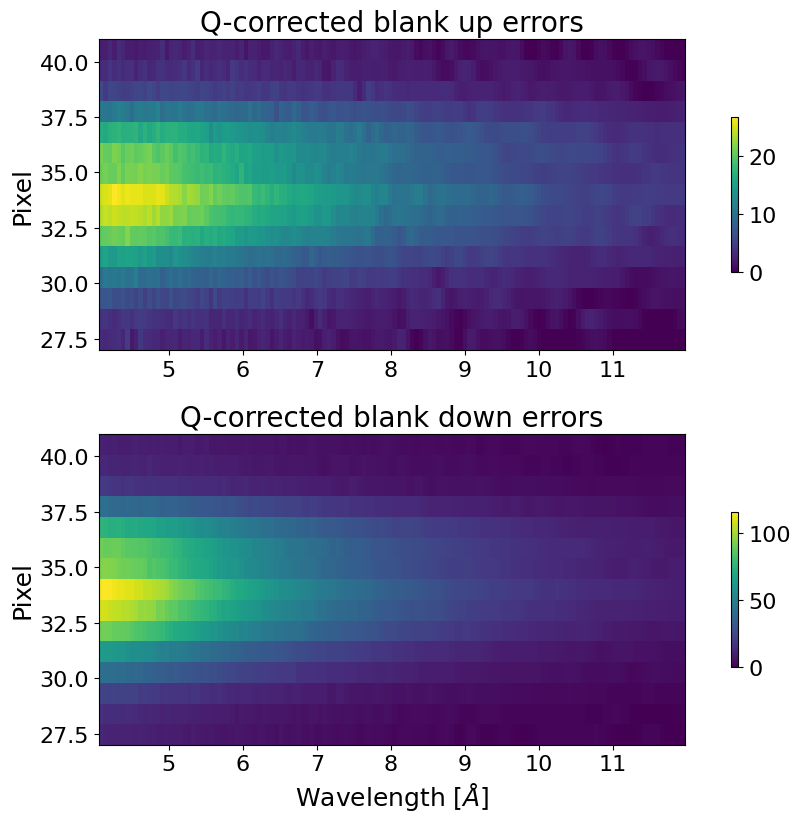

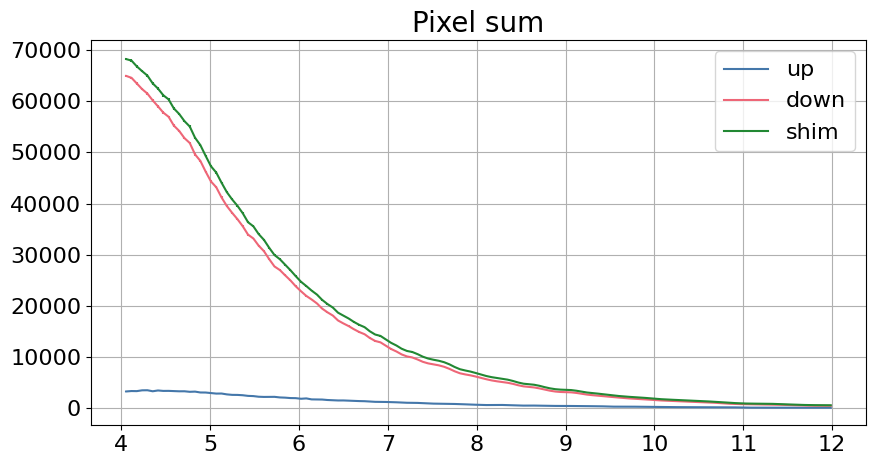

In [25]:
qlam_blank,qup_blank,qup_errs_blank = get_constant_Q(up_blank,up_errs_blank,lam_b,pixs,34,.35)
_,qdn_blank,qdn_errs_blank = get_constant_Q(dn_blank,dn_errs_blank,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected blank up','Q-corrected blank down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected blank up errors','Q-corrected blank down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_blank,s1:=np.sum(qup_blank,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_blank,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_blank,s2:=np.sum(qdn_blank,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_blank,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_blank,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_blank,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_blank[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

##### Finding the center:

These plots show that that each of the blank data sets have a different center of mass. Also, the blank perp is much wider than the two blank para data sets (as expected).

All blank data summed 
Center pixel:
[up,down]: [34.16485 34.11769] -> 34
Pixels used:
[31 32 33 34 35 36 37] : 7 total.


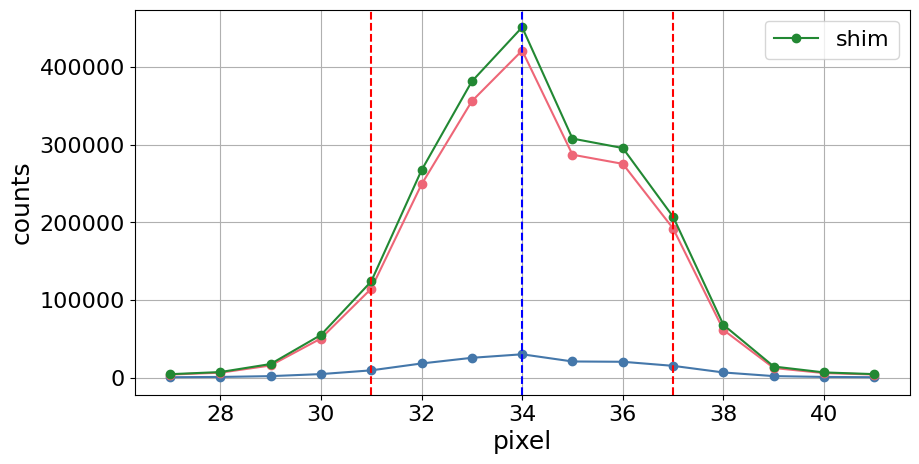

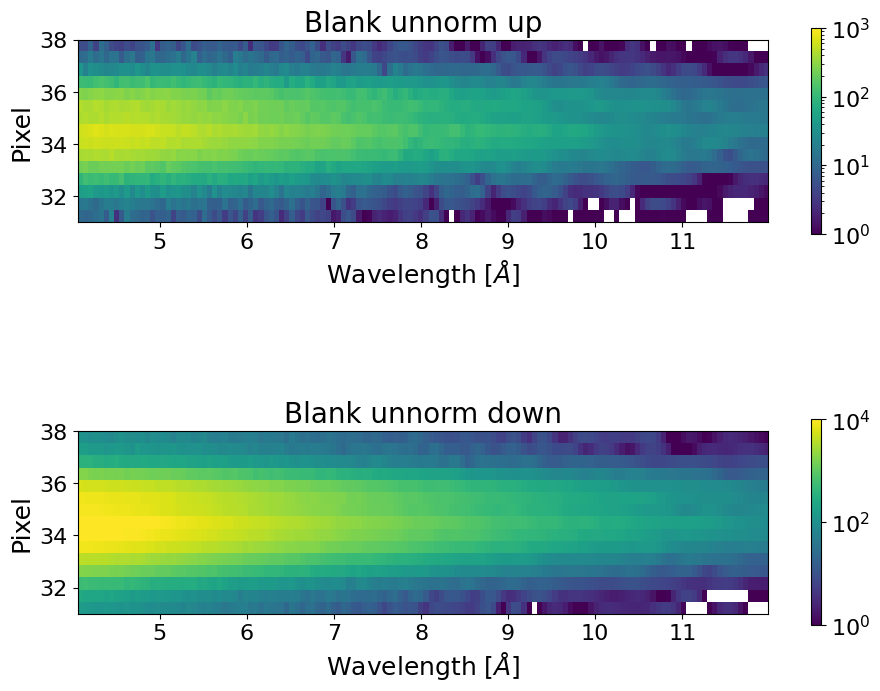

In [71]:
print('All blank data summed \n','='*80)
CENTER_PIXEL,PIXELS = get_center(qup_blank,qdn_blank,pname_b,threshold=.2)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=1e3))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_blank,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

if False:
    print('='*80)  #not Q-corrected
    _ = get_center(up_blank,dn_blank,pname_b)
    _ = get_center(up_b_perp,dn_b_perp,pname_b_perp)
    _ = get_center(up_b_para1,dn_b_para1,pname_b_para1)
    _ = get_center(up_b_para2,dn_b_para2,pname_b_para2)

##### Before pixel trimming and Q-correction:

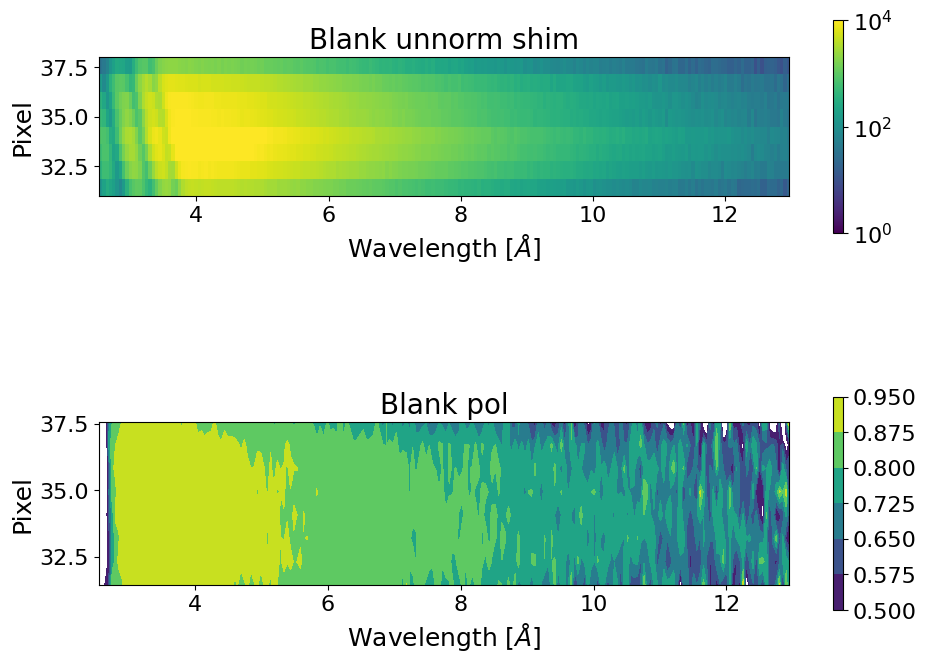

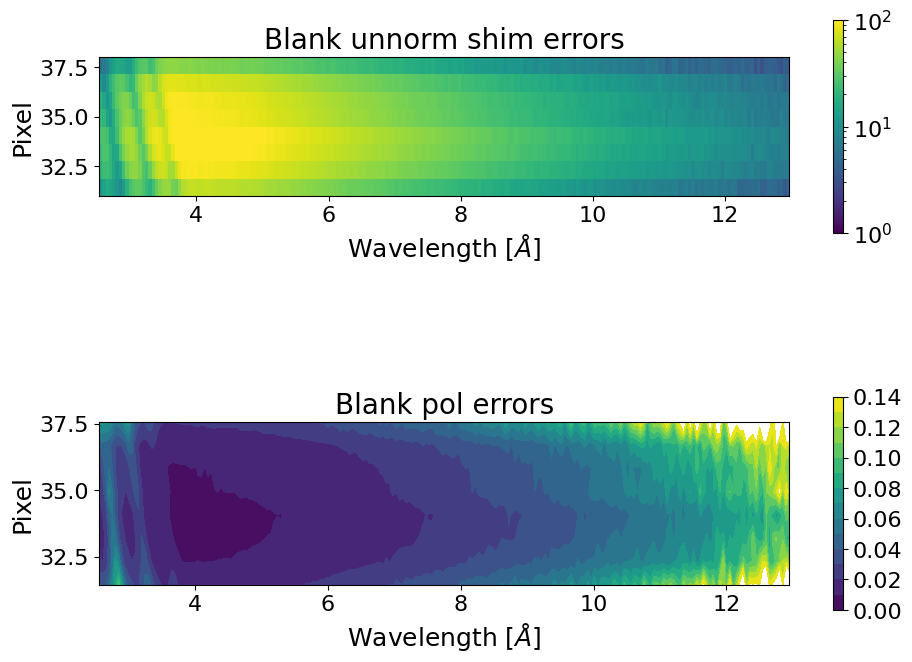

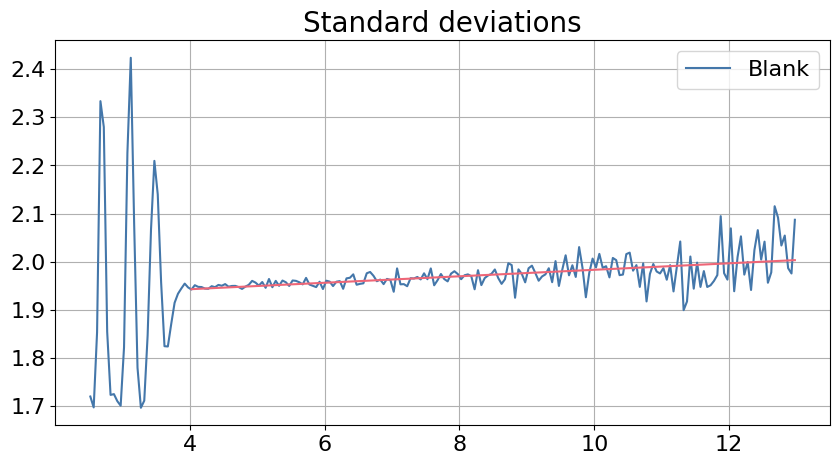

0.006734553073258098 1.916092137375799


In [27]:
blank_shim,blank_shim_errs,blank_pol,blank_pol_errs,blank_shim_std = get_pol_shim(up_blank,dn_blank,up_errs_blank,dn_errs_blank,pname_b,trim=PIXELS)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm shim','Blank pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(blank_shim,origin='lower',extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(blank_pol,origin='lower',extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(.5,.95,7)
    CS = axs[1].contourf(blank_pol,origin='lower',levels=cfill_levels,extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm shim errors','Blank pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(blank_shim_errs,origin='lower',extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(blank_pol_errs,origin='lower',extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.14,15)
    CS = axs[1].contourf(blank_pol_errs,origin='lower',levels=cfill_levels,extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Standard deviations']})
axs[0].plot(lam_b,blank_shim_std,label='Blank')
parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,lam_b[30:],blank_shim_std[30:])
plt.plot(lam_b[30:],f(lam_b[30:],*parms))
plt.legend()
plt.show()

print(*parms)

##### After pixel trimming and q-correction:

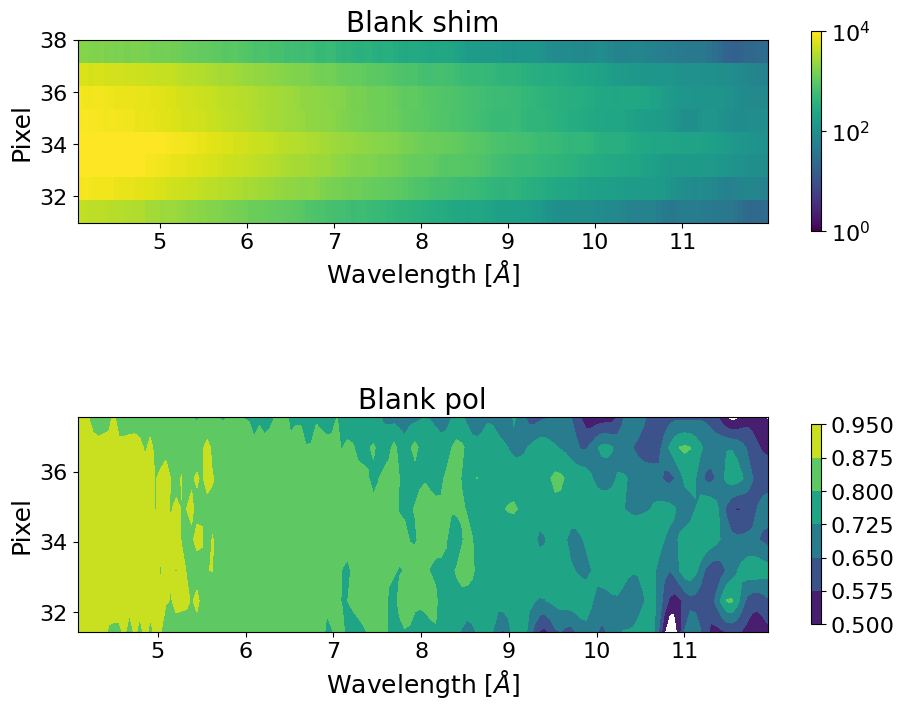

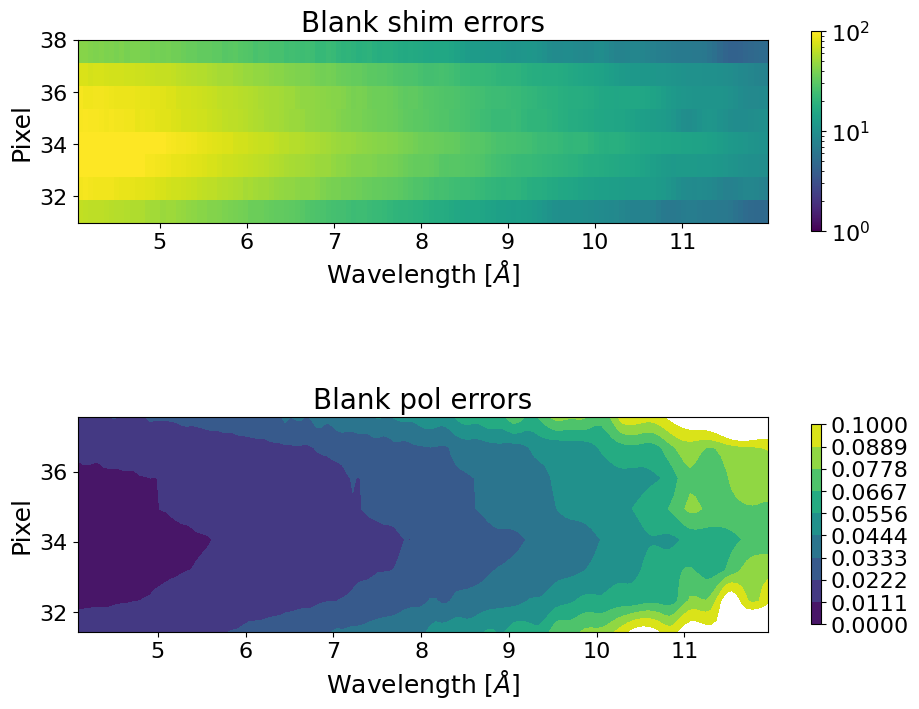

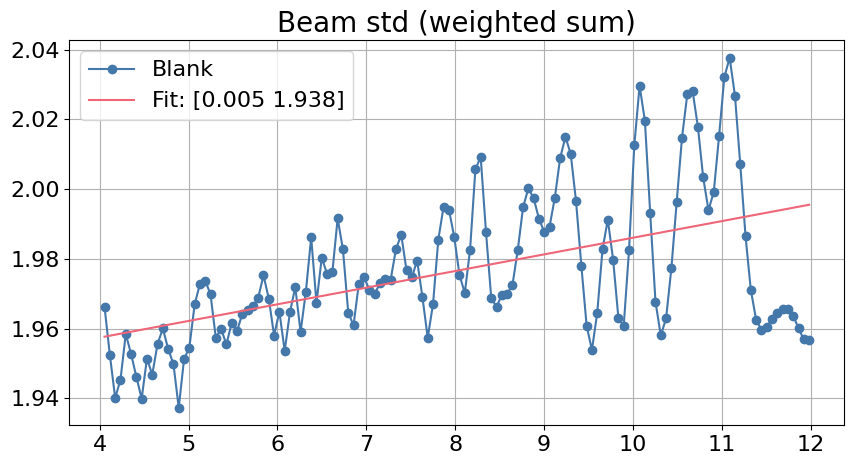

In [96]:
blank_shim,blank_shim_errs,blank_pol,blank_pol_errs,blank_shim_std = get_pol_shim(qup_blank,qdn_blank,qup_errs_blank,qdn_errs_blank,pname_b,trim=PIXELS)

fig,axs = prepare_plot({'grid':False,'title':['Blank shim','Blank pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(blank_shim,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(blank_pol,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(.5,.95,7)
    CS = axs[1].contourf(blank_pol,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Blank shim errors','Blank pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(blank_shim_errs,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(blank_pol_errs,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,10)
    CS = axs[1].contourf(blank_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
axs[0].plot(qlam_blank,blank_shim_std,'o-',label='Blank')
blank_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank,blank_shim_std)
plt.plot(qlam_blank,f(qlam_blank,*blank_parms),label=f'Fit: {np.round(blank_parms,3)}')
plt.legend()
plt.show()

##### Fitting $P_0$ from the blank sample:

Using Chebyshev polynomials to reduce Runge's phenomenon. Each pixel is fit independently because there is a large difference in polarization between each pixel.

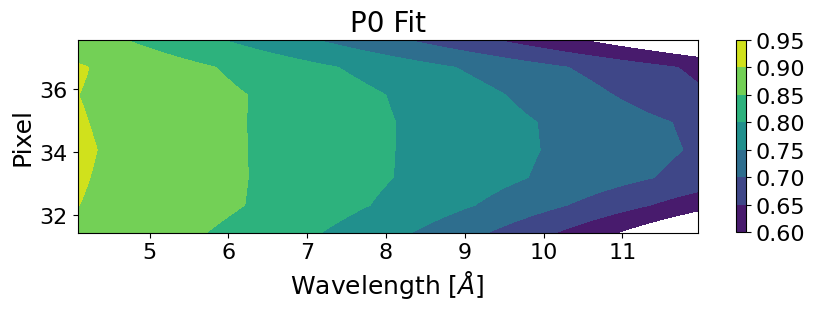

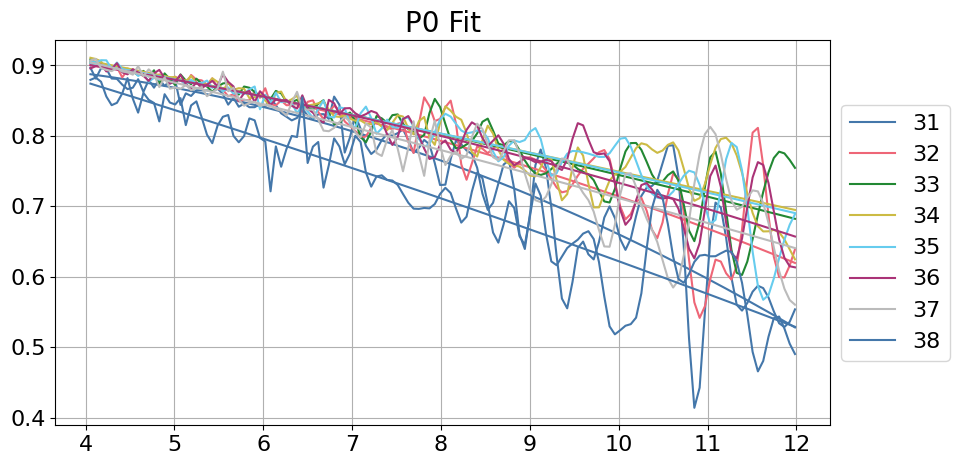

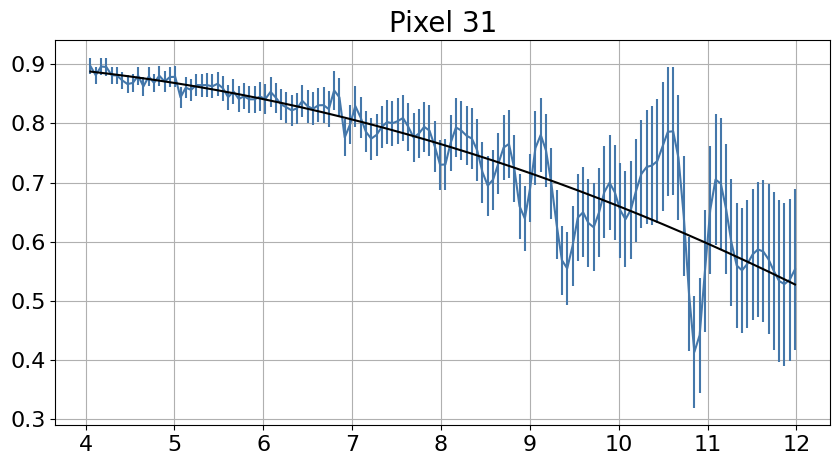

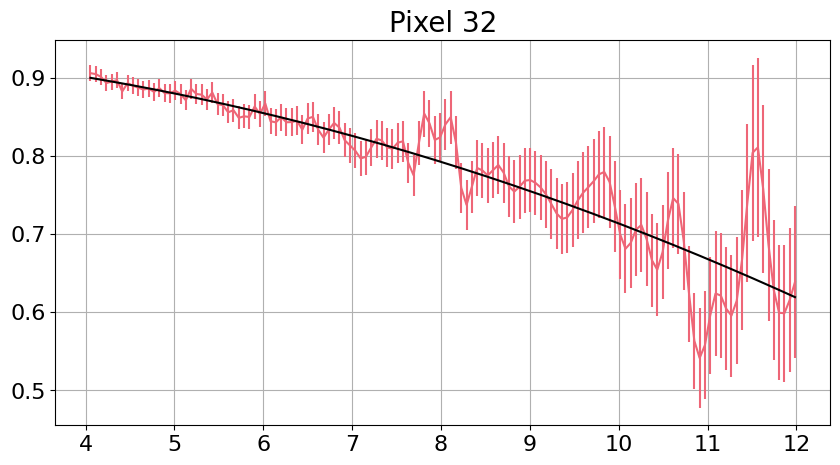

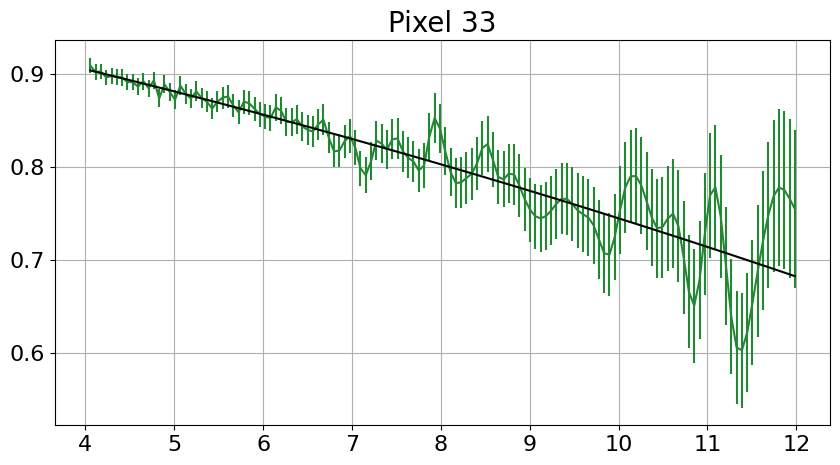

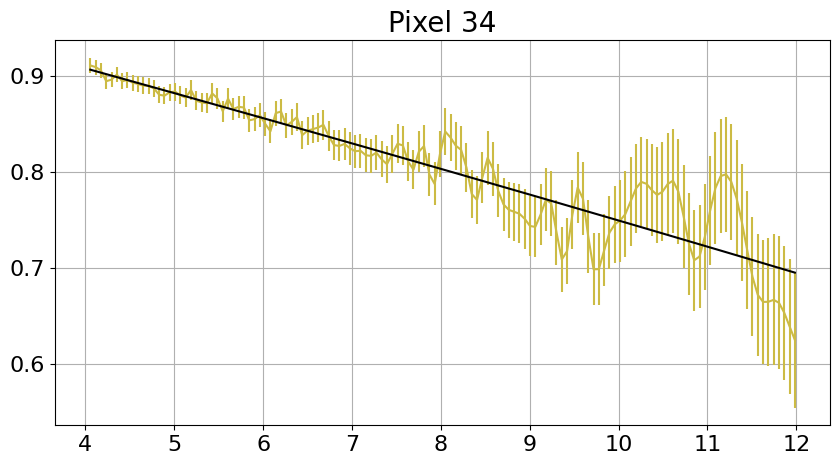

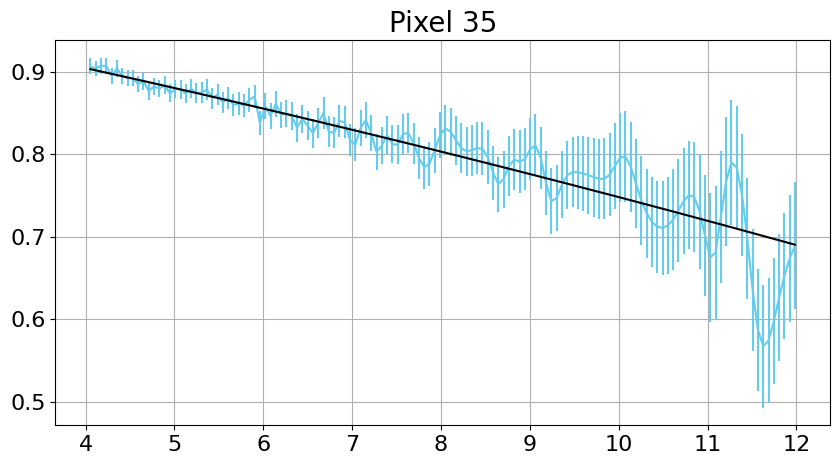

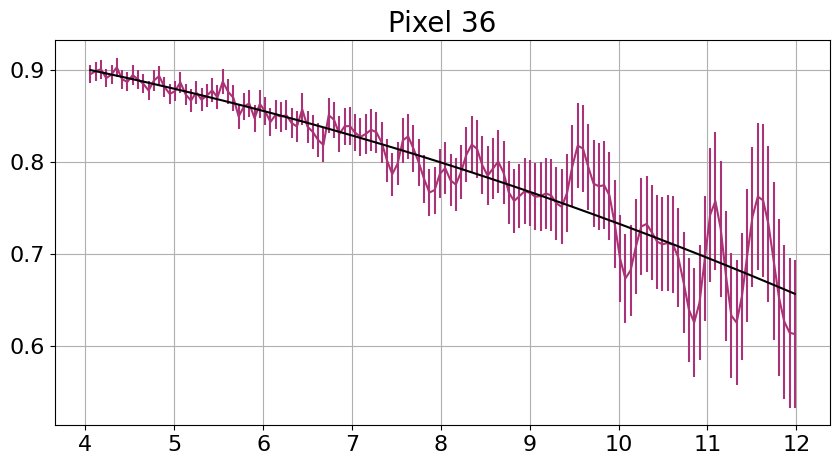

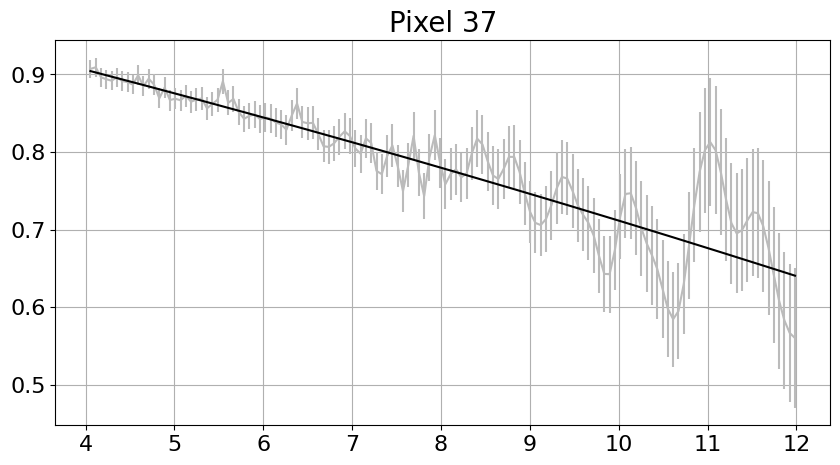

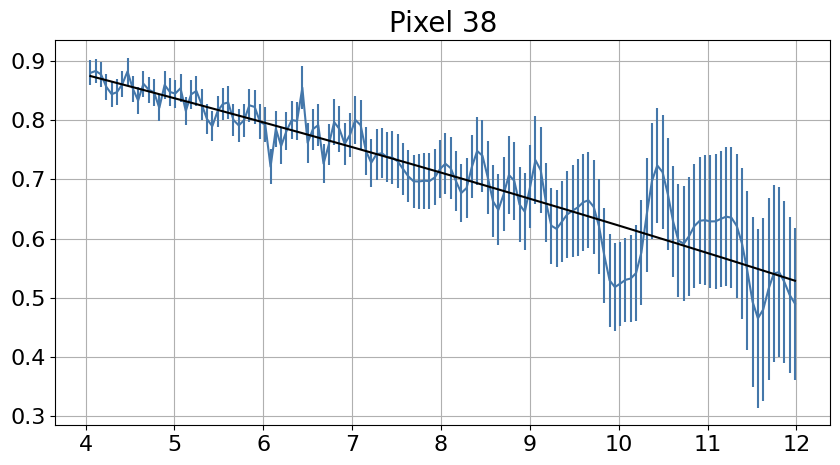

In [84]:
def do_fit(lam,data,err=None,deg=[0,1,2]):
    '''Performs and returns fit of P0 from the blank sample.
    Fits each pixel individually vs wavelength.'''
    c_fit = np.polynomial.chebyshev.Chebyshev.fit
    get_coeffs = np.polynomial.chebyshev.chebval
    
    if err is None:
        fitted = np.array([get_coeffs(lam,c_fit(lam,y,deg,w=None).convert().coef) for y in data])
    else:
        fitted = np.array([get_coeffs(lam,c_fit(lam,y,deg,w=1/e).convert().coef) for y,e in zip(data,err)])
    return fitted

P0 = do_fit(qlam_blank,blank_pol,err=blank_pol_errs)

fig,axs = prepare_plot({'grid':False,'title':['P0 Fit'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel']})
if False:
    im1 = axs[0].imshow(P0,origin='lower',extent=(qlam_blank[0],qlam_blank[-1],pixs[0],pixs[-1]),aspect=.2)
    plt.colorbar(im1,shrink=.5)
if True:
    cfill_levels = np.linspace(.6,.95,8)
    CS = axs[0].contourf(P0,origin='lower',levels=cfill_levels,extent=(qlam_blank[0],qlam_blank[-1],PIXELS[0],PIXELS[-1]))
    axs[0].set_aspect(0.4)
    #CS2 = axs[1].contour(blank_pol,origin='lower',levels=cfill_levels,extent=(lam_b[0],lam_b[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.show()

if True:
    fig,axs = prepare_plot({'title':[f'P0 Fit']})
    for indx,(pixel,fit,data,error) in enumerate(zip(PIXELS,P0,blank_pol,blank_pol_errs)):
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        #axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        axs[0].plot(qlam_blank,fit,label=f'{pixel}',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if True:
    for indx,(pixel,fit,data,error) in enumerate(zip(PIXELS,P0,blank_pol,blank_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        axs[0].plot(qlam_blank,fit,label=f'{indx}',color='black')
        plt.show()

### Sample magnetization perpendicular to the guide field (perp)

***

The shim intensity shows 2 distinct peaks. Technically, the beam has the same center, but I'm missing quite a few counts from pixel 8, so the P0 normalization needs to additionally include at least that pixel.

General cell progression:
1. Load data
2. Do Q-correction
3. Trim beam to center determined by the blank sample
4. Get normalized shim and polarization

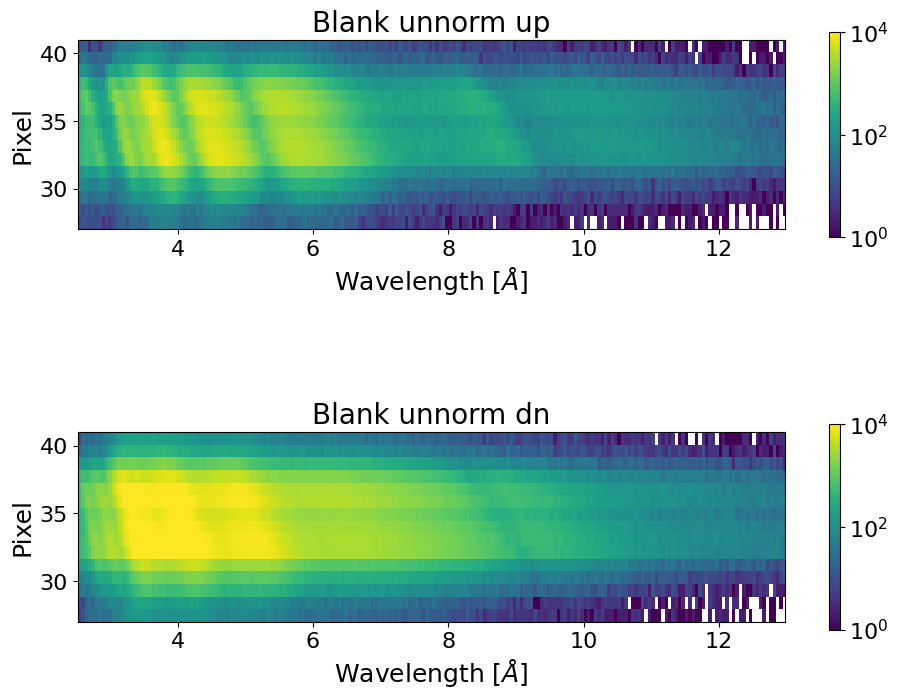

In [64]:
pixs = np.arange(27,42)  #rough detector pixel trimming
(lam_perp,up_perp,eup_perp),pname_perp = load_data_2D(r"perp_p35\\up.txt",pix_trim=pixs)
(_,dn_perp,edn_perp),_ = load_data_2D(r"perp_p35\\dn.txt",pix_trim=pixs)
lam_perp = lam_perp[0]

up_perp,up_errs_perp = unnormalize(up_perp,eup_perp)
dn_perp,dn_errs_perp = unnormalize(dn_perp,edn_perp)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_perp,origin='lower',extent=(lam_perp[0],lam_perp[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_perp,origin='lower',extent=(lam_perp[0],lam_perp[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

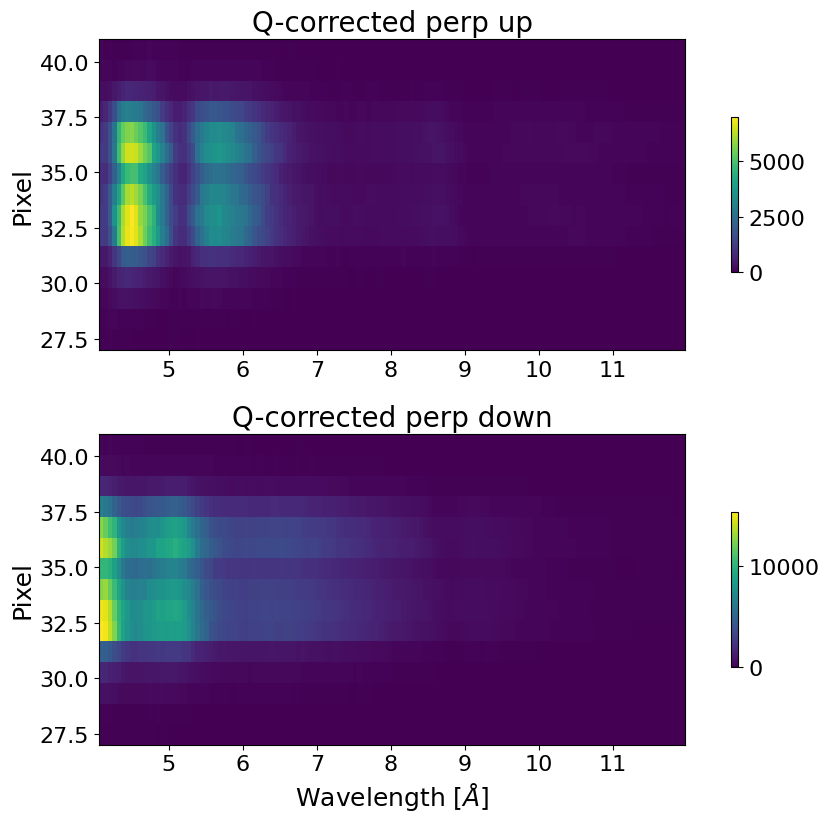

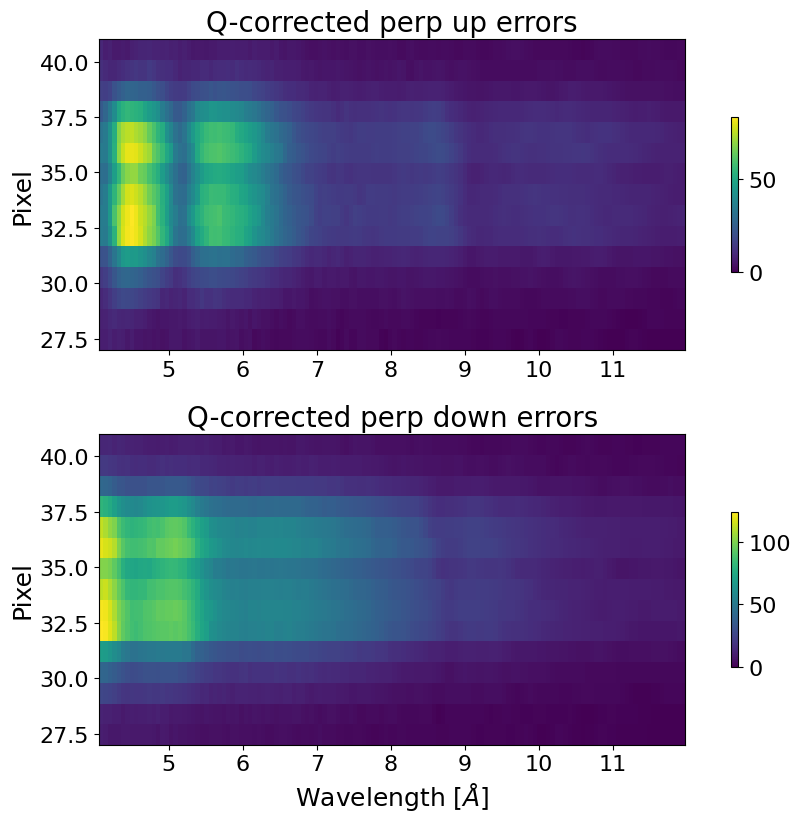

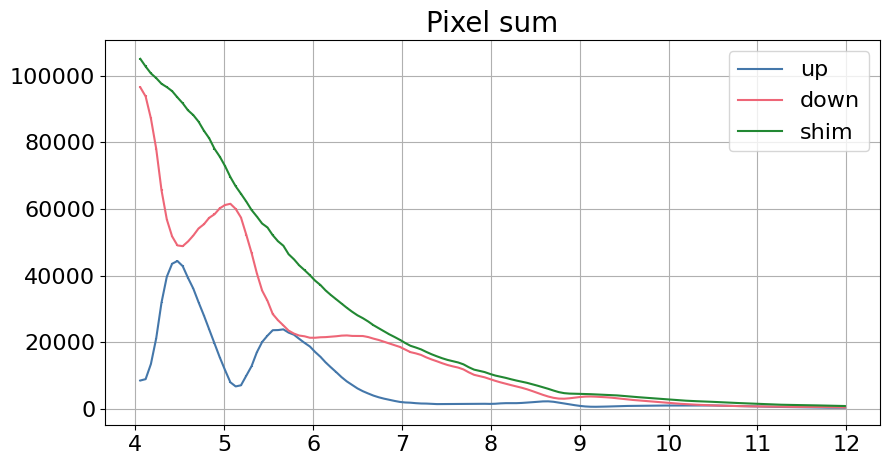

In [65]:
qlam_perp,qup_perp,qup_errs_perp = get_constant_Q(up_perp,up_errs_perp,lam_b,pixs,34,.35)
_,qdn_perp,qdn_errs_perp = get_constant_Q(dn_perp,dn_errs_perp,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected perp up','Q-corrected perp down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected perp up errors','Q-corrected perp down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_perp,s1:=np.sum(qup_perp,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_perp,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_perp,s2:=np.sum(qdn_perp,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_perp,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_perp,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_perp,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_perp[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

Center pixel:
[up,down]: [34.59455 34.60982] -> 35
Pixels used:
[31 32 33 34 35 36 37 38] : 8 total.


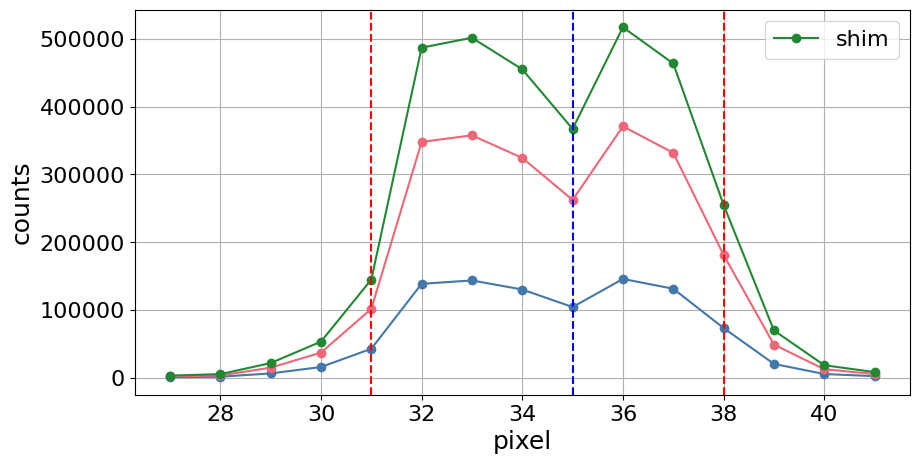

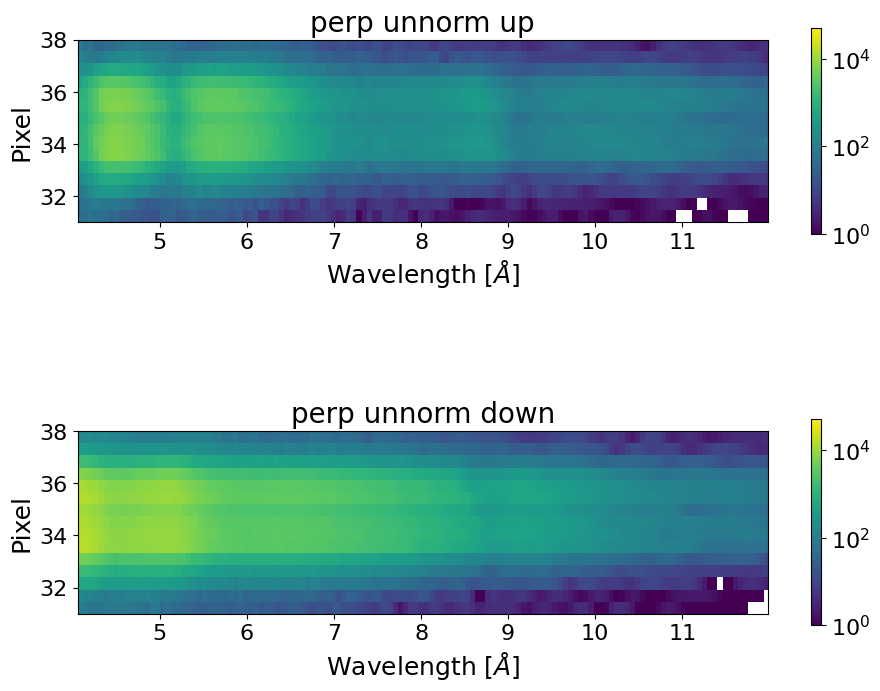

In [73]:
_ = get_center(qup_perp,qdn_perp,pname_b,threshold=.2)

fig,axs = prepare_plot({'grid':False,'title':['perp unnorm up','perp unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_perp,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

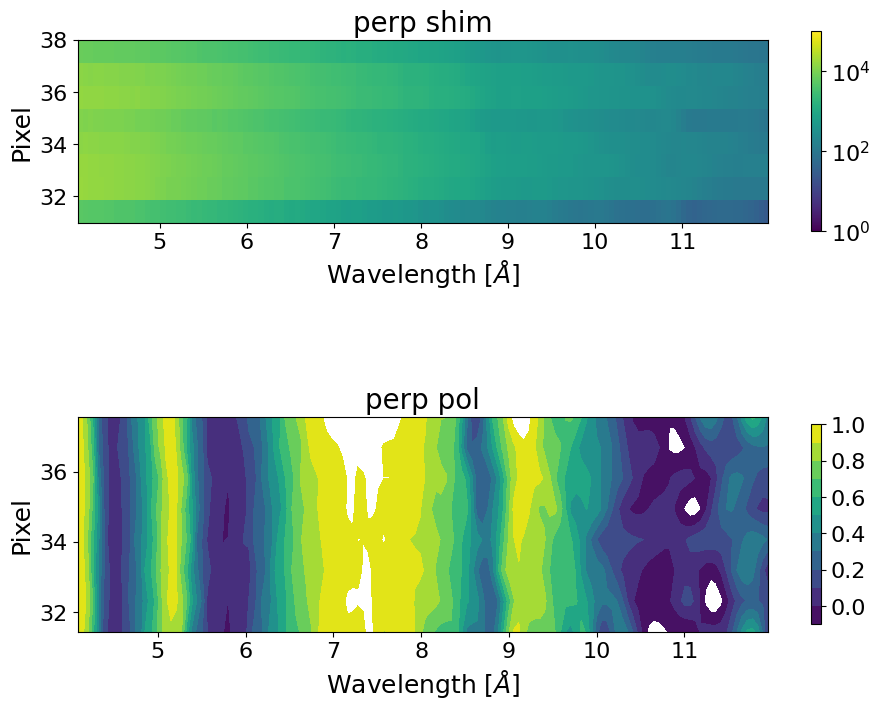

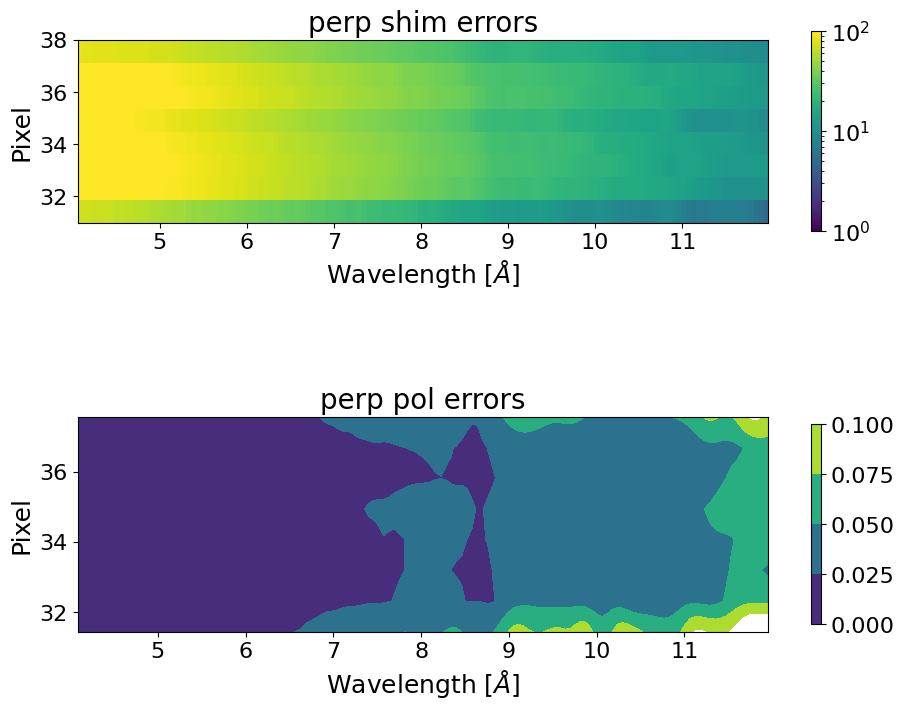

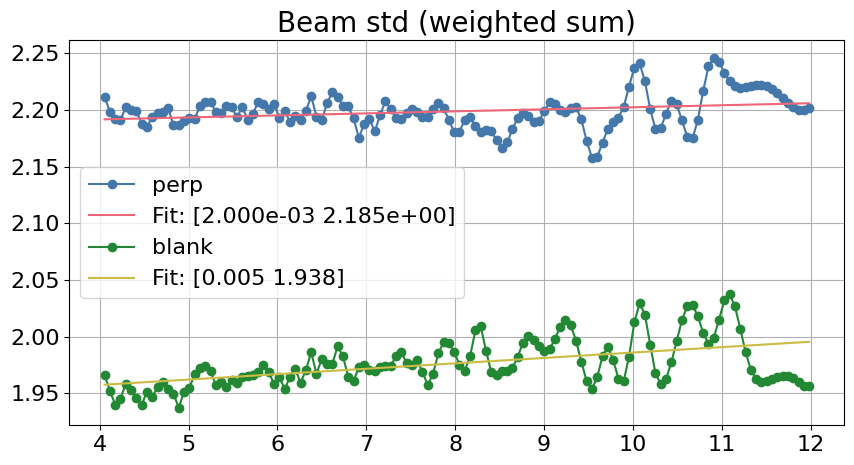

In [100]:
perp_shim,perp_shim_errs,perp_pol,perp_pol_errs,perp_shim_std = get_pol_shim(qup_perp,qdn_perp,qup_errs_perp,qdn_errs_perp,pname_b,trim=PIXELS)
perp_pol = perp_pol/P0  #normalizing to blank sample
perp_pol_errs = perp_pol_errs/P0

fig,axs = prepare_plot({'grid':False,'title':['perp shim','perp pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(perp_shim,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(perp_pol,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(-.1,1,12)
    CS = axs[1].contourf(perp_pol,origin='lower',levels=cfill_levels,extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(perp_pol,origin='lower',levels=cfill_levels,extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['perp shim errors','perp pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(perp_shim_errs,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(perp_pol_errs,origin='lower',extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,5)
    CS = axs[1].contourf(perp_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(perp_pol,origin='lower',levels=cfill_levels,extent=(qlam_perp[0],qlam_perp[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
axs[0].plot(qlam_perp,perp_shim_std,'o-',label='perp')
perp_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_perp,perp_shim_std)
axs[0].plot(qlam_perp,f(qlam_perp,*perp_parms),label=f'Fit: {np.round(perp_parms,3)}')
axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank')
axs[0].plot(qlam_blank,f(qlam_blank,*blank_parms),label=f'Fit: {np.round(blank_parms,3)}')
plt.legend()
plt.show()

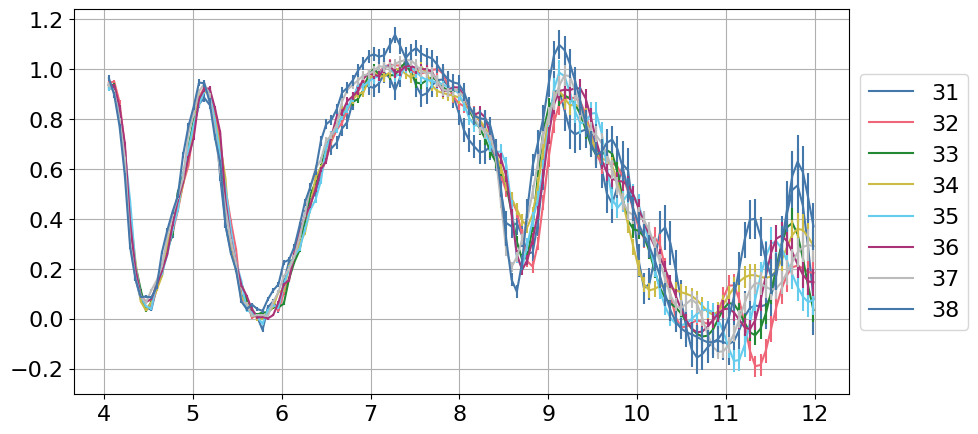

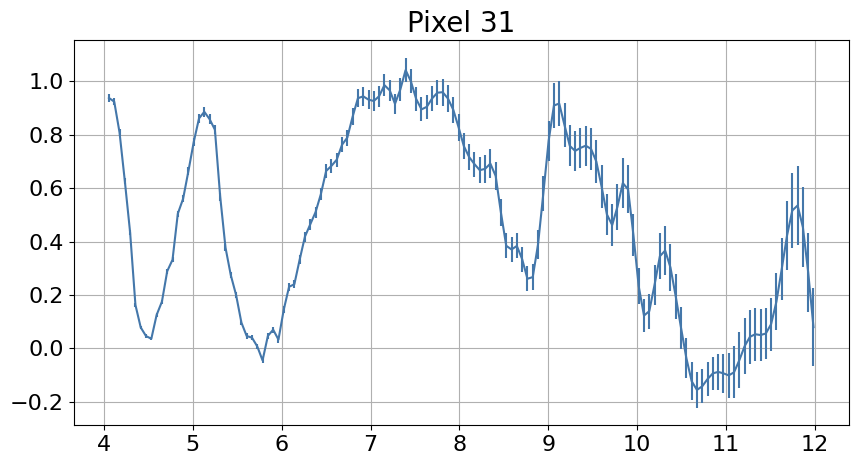

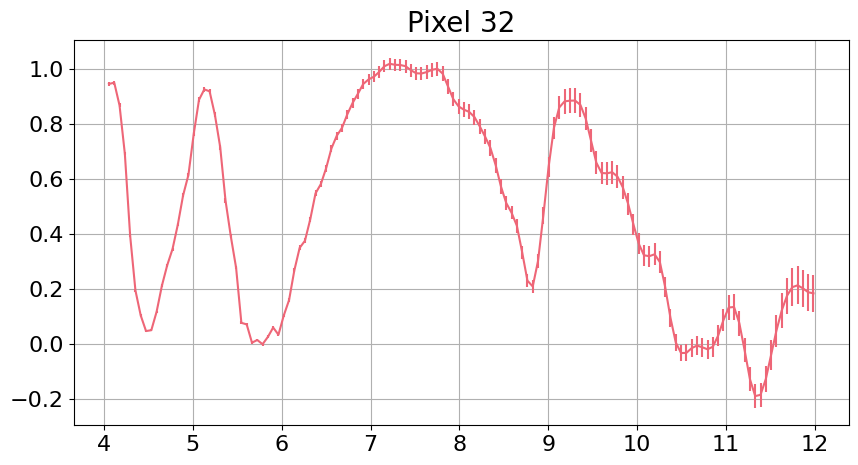

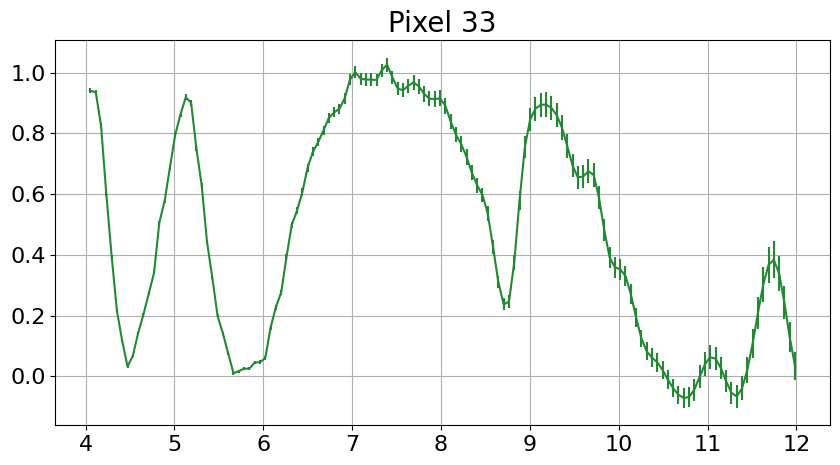

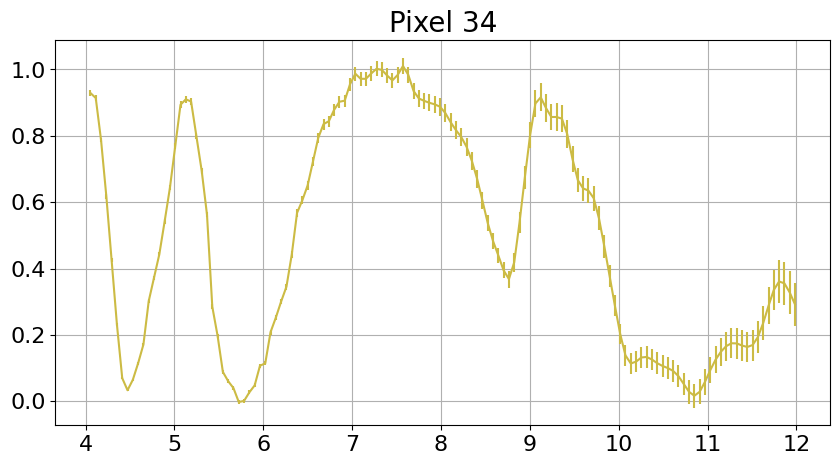

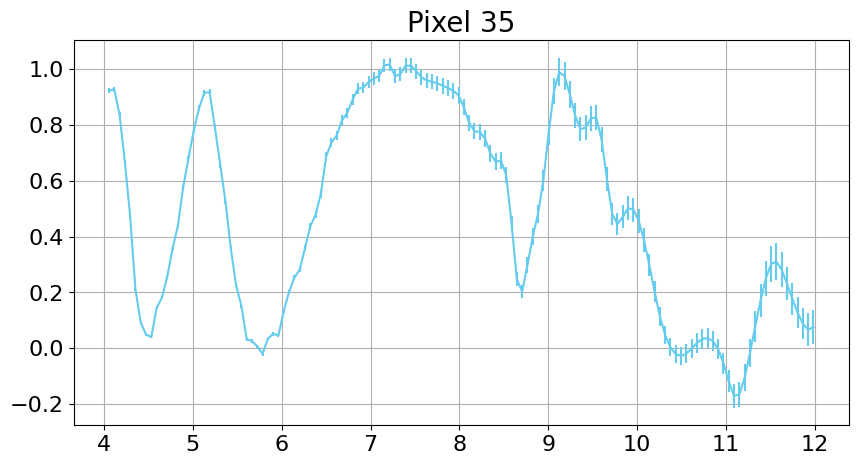

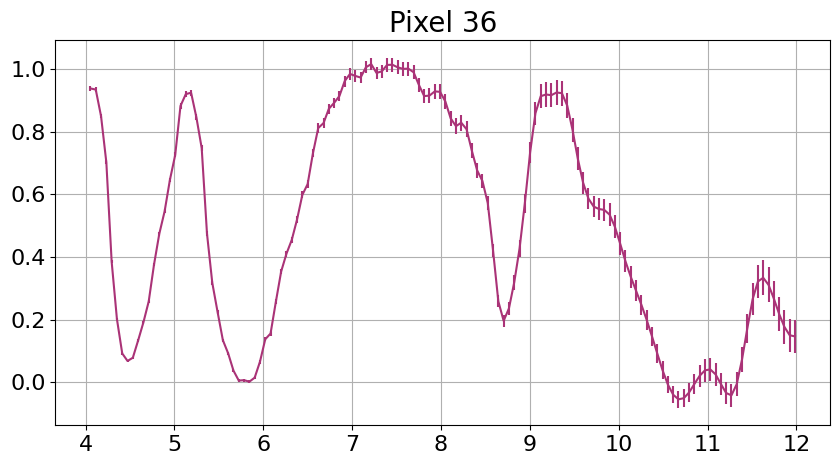

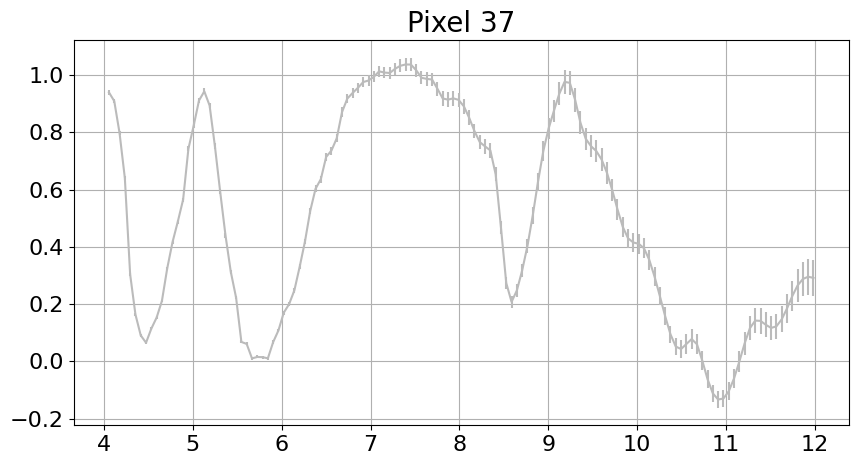

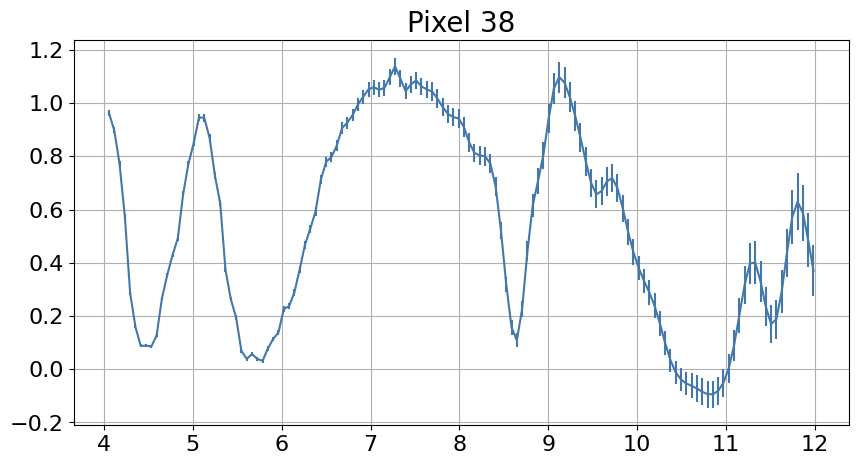

In [119]:
if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,perp_pol,perp_pol_errs)):
        axs[0].plot(qlam_perp,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_perp,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if True:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,perp_pol,perp_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

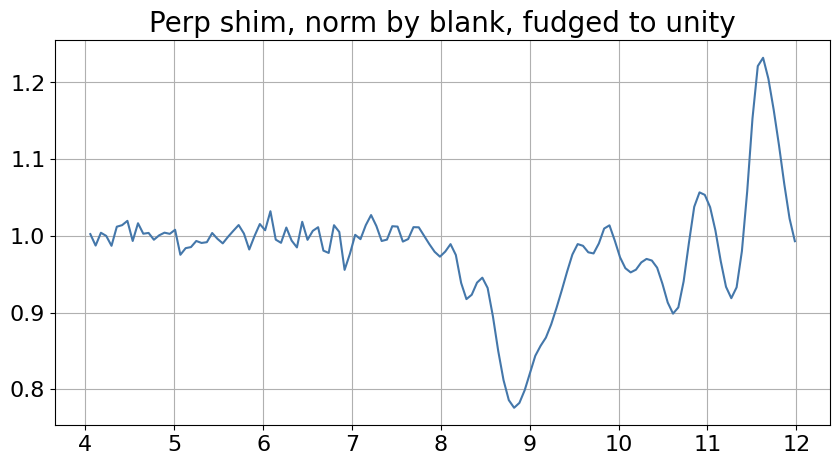

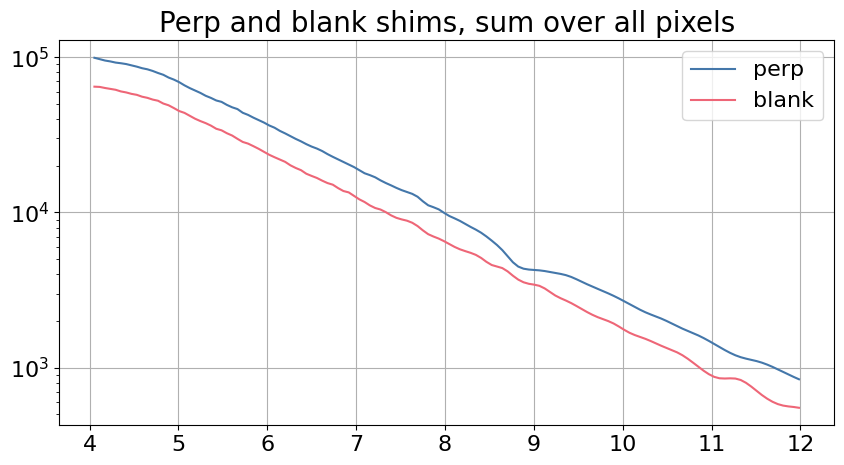

In [161]:
assert perp_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'
perp_shim_norm = np.sum(perp_shim/blank_shim,axis=0)
#perp_shim_norm_errors = np.sqrt(perp_shim**2 + blank_shim**2)

if True:
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:60],perp_shim_norm[:60])
    perp_shim_norm = perp_shim_norm/f(qlam_blank,*temp)

fig,axs = prepare_plot({'title':['Perp shim, norm by blank, fudged to unity']})
axs[0].plot(qlam_blank,perp_shim_norm)
#axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
#axs[0].plot(qlam_blank[:60],f(qlam_blank[:60],*temp))
plt.show()

fig,axs = prepare_plot({'title':['Perp and blank shims, sum over all pixels']})
axs[0].set_yscale('log')
axs[0].plot(qlam_blank,np.sum(perp_shim,axis=0),label='perp')
axs[0].plot(qlam_blank,np.sum(blank_shim,axis=0),label='blank')
plt.legend()
plt.show()

### Sample parallel, no grating
***

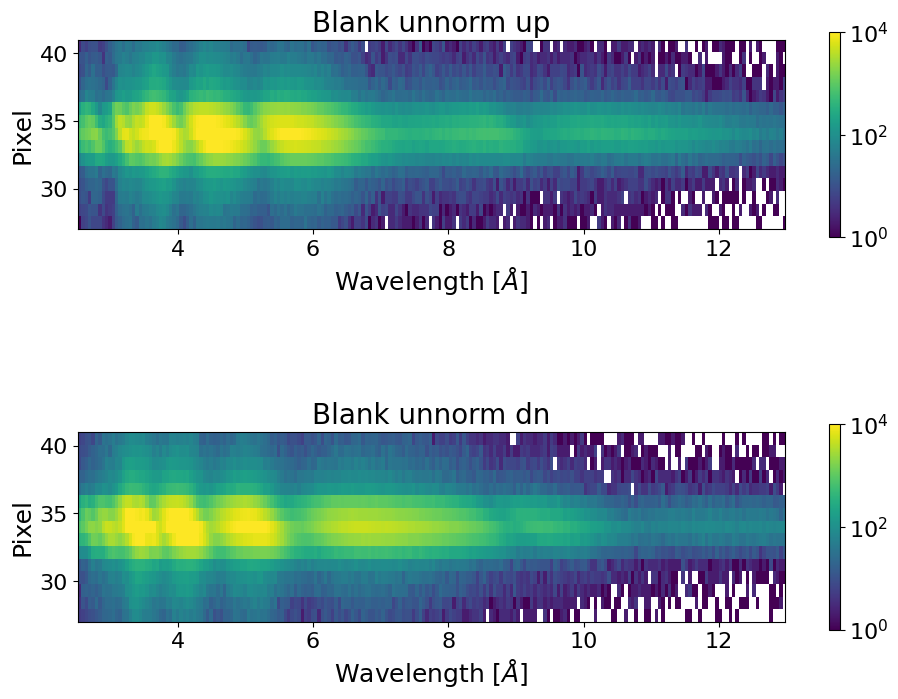

In [142]:
pixs = np.arange(27,42)  #rough detector pixel trimming
(lam_para,up_para,eup_para),pname_para = load_data_2D(r"para_p35\\up.txt",pix_trim=pixs)
(_,dn_para,edn_para),_ = load_data_2D(r"para_p35\\dn.txt",pix_trim=pixs)
lam_para = lam_para[0]

up_para,up_errs_para = unnormalize(up_para,eup_para)
dn_para,dn_errs_para = unnormalize(dn_para,edn_para)

fig,axs = prepare_plot({'grid':False,'title':['Blank unnorm up','Blank unnorm dn'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(up_para,origin='lower',extent=(lam_para[0],lam_para[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(dn_para,origin='lower',extent=(lam_para[0],lam_para[-1],pixs[0],pixs[-1]),aspect=.2,\
                    norm=LogNorm(vmin=1, vmax=1e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

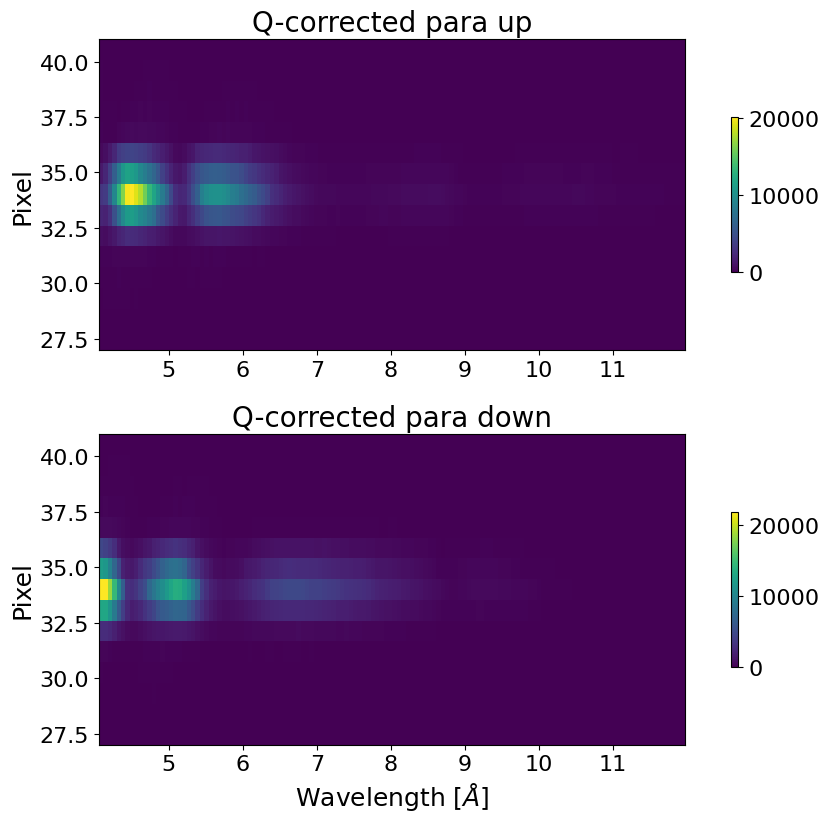

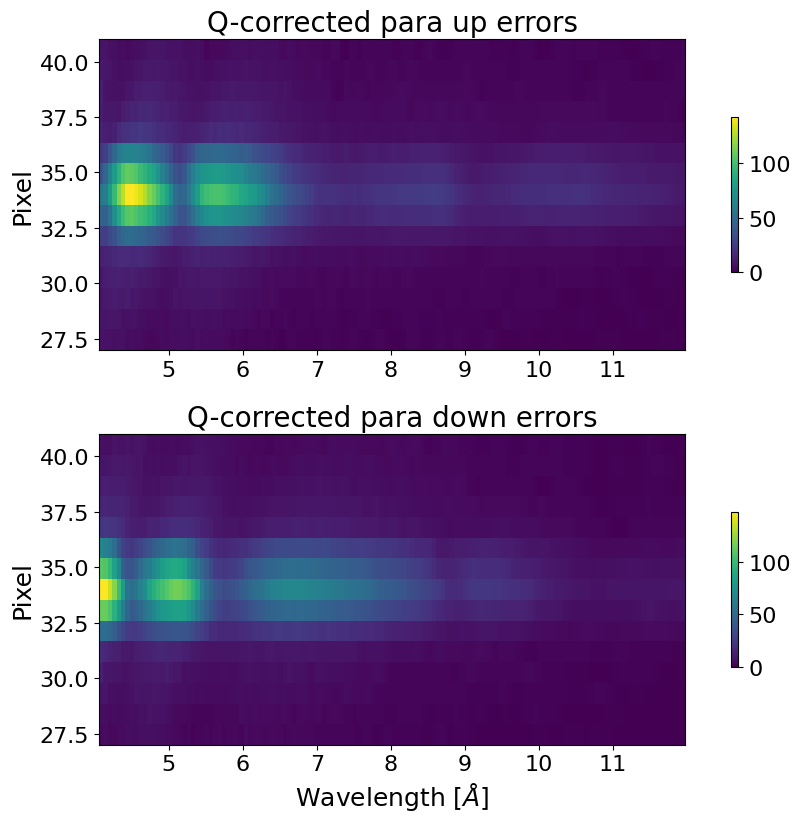

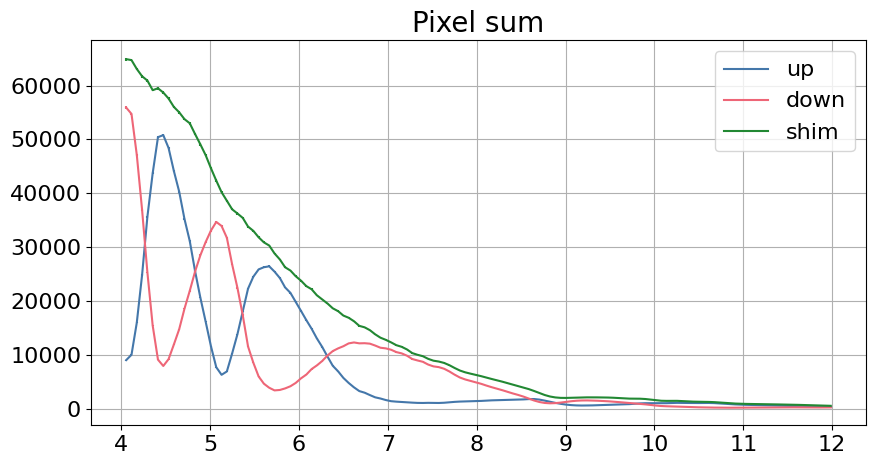

In [143]:
qlam_para,qup_para,qup_errs_para = get_constant_Q(up_para,up_errs_para,lam_b,pixs,34,.35)
_,qdn_para,qdn_errs_para = get_constant_Q(dn_para,dn_errs_para,lam_b,pixs,34,.35)

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para up','Q-corrected para down'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para,origin='lower',extent=(qlam_para[0],qlam_para[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para,origin='lower',extent=(qlam_para[0],qlam_para[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['Q-corrected para up errors','Q-corrected para down errors'],\
                        'xlabel':[None,r'Wavelength $[\AA$]'],'ylabel':['Pixel'],\
                        'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_errs_para,origin='lower',extent=(qlam_para[0],qlam_para[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_errs_para,origin='lower',extent=(qlam_para[0],qlam_para[-1],pixs[0],pixs[-1]),aspect=.3)
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Pixel sum']})
if True:
    axs[0].plot(qlam_para,s1:=np.sum(qup_para,axis=0),'-',label='up',color='C0')
    axs[0].errorbar(qlam_para,s1,yerr=np.sqrt(s1),linestyle='',color='C0')
    axs[0].plot(qlam_para,s2:=np.sum(qdn_para,axis=0),'-',label='down',color='C1')
    axs[0].errorbar(qlam_para,s2,yerr=np.sqrt(s2),linestyle='',color='C1')
    axs[0].plot(qlam_para,s1+s2,'-',label='shim',color='C2')
    axs[0].errorbar(qlam_para,sh:=s1+s2,yerr=np.sqrt(s1+s2),linestyle='',color='C2')
if False:
    axs[0].plot(qt:=qlam_para[25:-25],p:=((s2-s1)/(s1+s2))[25:-25],'-',label='pol',color='C3')
    axs[0].errorbar(qt,p,yerr=np.sqrt((1 - p**2)/2/sh[25:-25]),linestyle='',color='C3')
plt.legend()
plt.show()

Center pixel:
[up,down]: [34.13941 34.12544] -> 34
Pixels used:
[33 34 35 36] : 4 total.


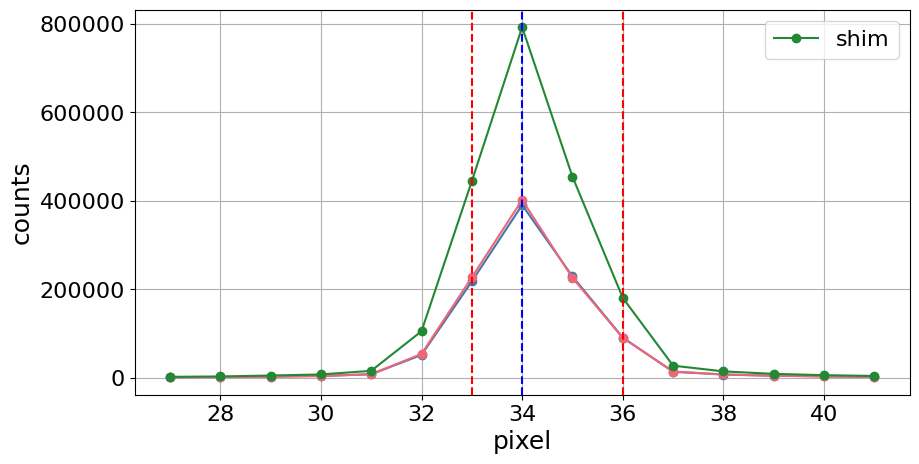

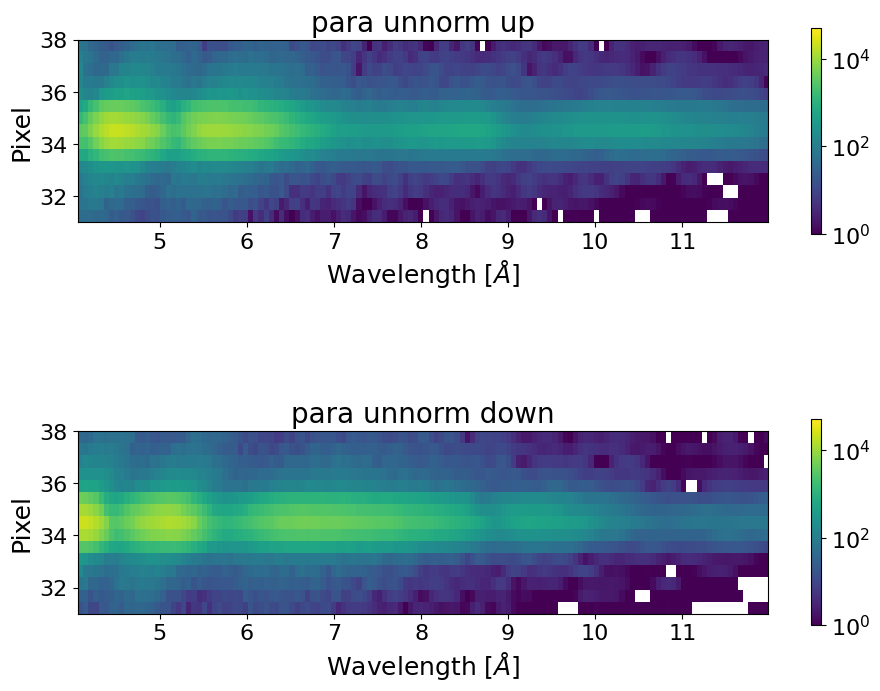

In [144]:
_ = get_center(qup_para,qdn_para,pname_b,threshold=.2)

fig,axs = prepare_plot({'grid':False,'title':['para unnorm up','para unnorm down'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(qup_para,origin='lower',extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im1,shrink=.5)
im2 = axs[1].imshow(qdn_para,origin='lower',extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),aspect=.3,\
                    norm=LogNorm(vmin=1, vmax=5e4))
plt.colorbar(im2,shrink=.5)
plt.tight_layout()
plt.show()

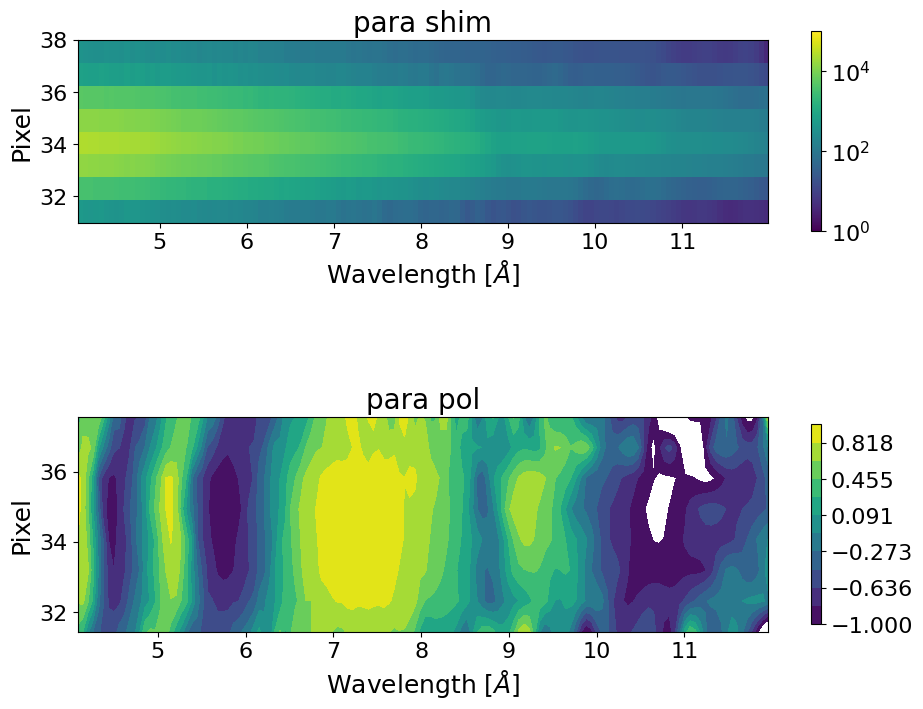

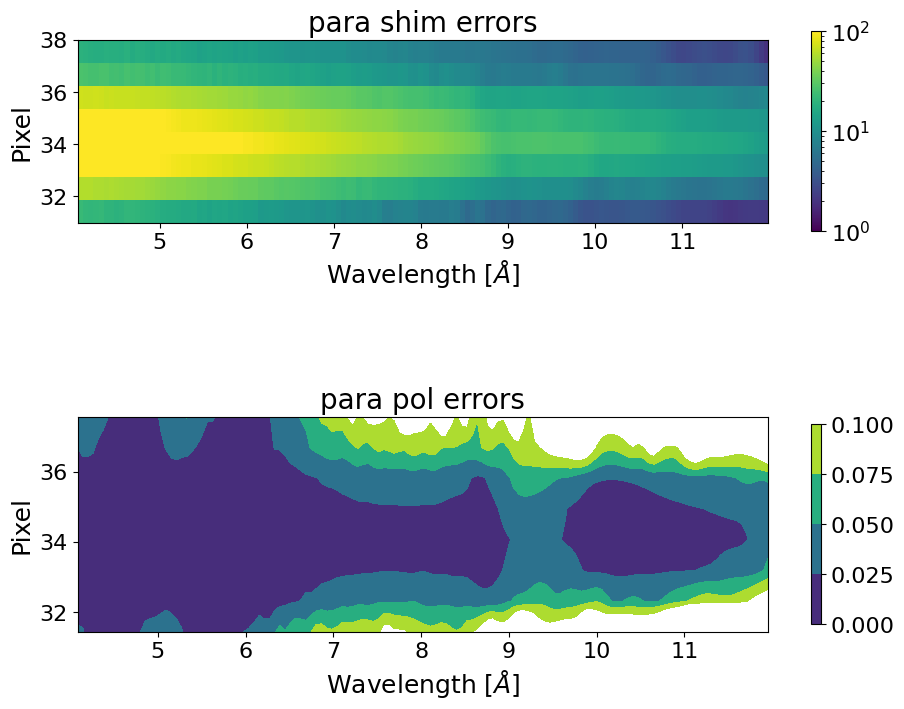

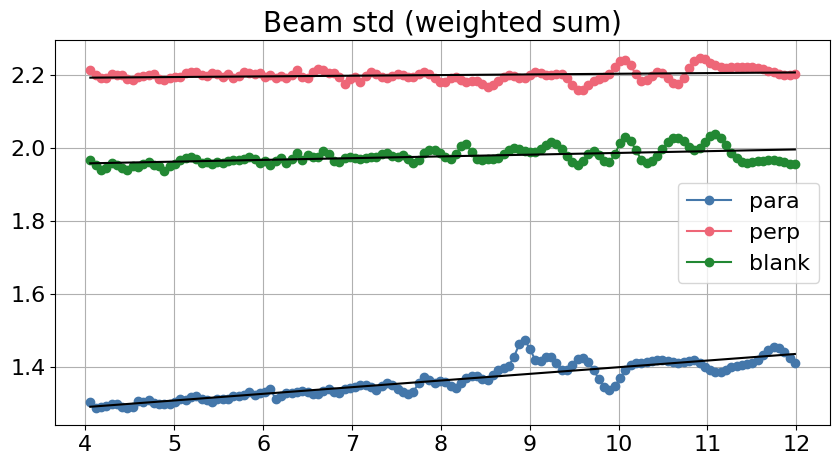

In [154]:
para_shim,para_shim_errs,para_pol,para_pol_errs,para_shim_std = get_pol_shim(qup_para,qdn_para,qup_errs_para,qdn_errs_para,pname_b,trim=PIXELS)
para_pol = para_pol/P0  #normalizing to blank sample
para_pol_errs = para_pol_errs/P0

fig,axs = prepare_plot({'grid':False,'title':['para shim','para pol'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_shim,origin='lower',extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e5))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_pol,origin='lower',extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=.5,vmax=.95)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(-1,1,12)
    CS = axs[1].contourf(para_pol,origin='lower',levels=cfill_levels,extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_pol,origin='lower',levels=cfill_levels,extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'grid':False,'title':['para shim errors','para pol errors'],\
                        'xlabel':[r'Wavelength $[\AA$]'],'ylabel':['Pixel'],'size':fs_double,'figs':(2,1)})
im1 = axs[0].imshow(para_shim_errs,origin='lower',extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),aspect=.3,norm=LogNorm(vmin=1, vmax=1e2))
plt.colorbar(im1,shrink=.5)
if False:
    im2 = axs[1].imshow(para_pol_errs,origin='lower',extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),aspect=.3,vmin=0,vmax=.15)
    plt.colorbar(im2,shrink=.5)
if True:
    cfill_levels = np.linspace(0,.1,5)
    CS = axs[1].contourf(para_pol_errs,origin='lower',levels=cfill_levels,extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]))
    axs[1].set_aspect(0.4)
    #CS2 = axs[1].contour(para_pol,origin='lower',levels=cfill_levels,extent=(qlam_para[0],qlam_para[-1],PIXELS[0],PIXELS[-1]),colors='black')
    plt.colorbar(CS,shrink=.5)
plt.tight_layout()
plt.show()

fig,axs = prepare_plot({'title':['Beam std (weighted sum)']})
axs[0].plot(qlam_para,para_shim_std,'o-',label='para')
para_parms,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_para,para_shim_std)
axs[0].plot(qlam_para,f(qlam_para,*para_parms),color='black')#,label=f'Fit: {np.round(para_parms,3)}')
axs[0].plot(qlam_blank,perp_shim_std,'o-',label=f'perp')
axs[0].plot(qlam_blank,f(qlam_blank,*perp_parms),color='black')#,label=f'Fit: {np.round(perp_parms,3)}')
axs[0].plot(qlam_blank,blank_shim_std,'o-',label=f'blank')
axs[0].plot(qlam_blank,f(qlam_blank,*blank_parms),color='black')#,label=f'Fit: {np.round(blank_parms,3)}')
#axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].legend()
plt.show()

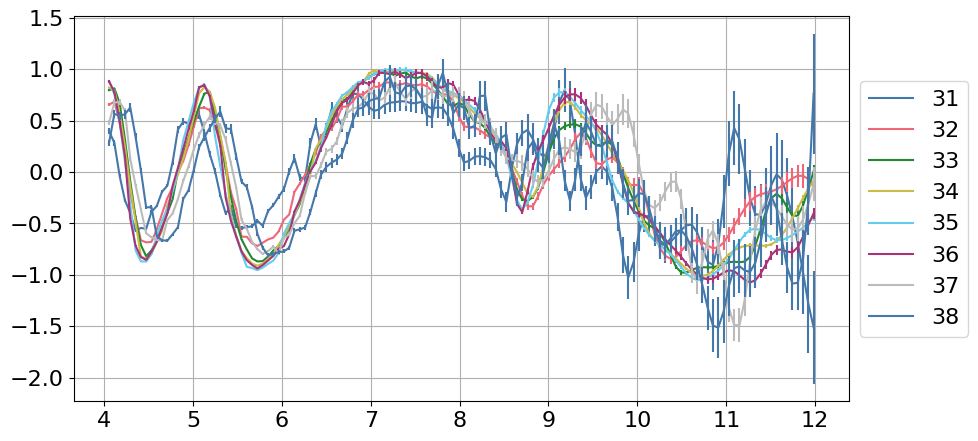

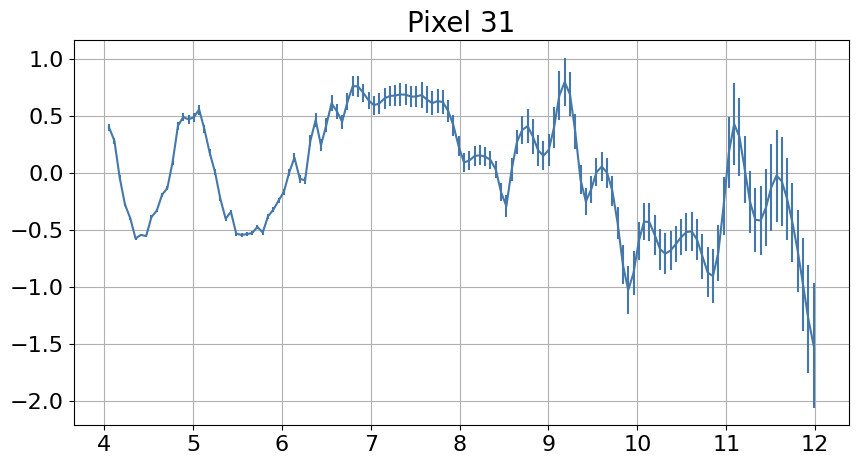

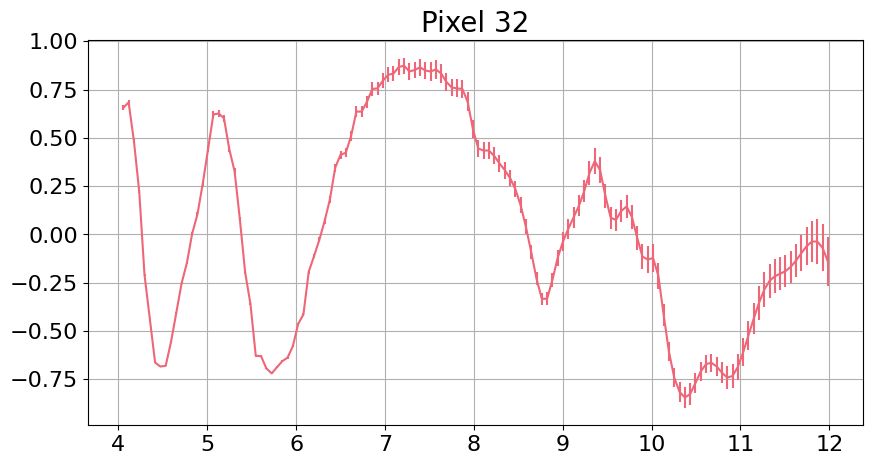

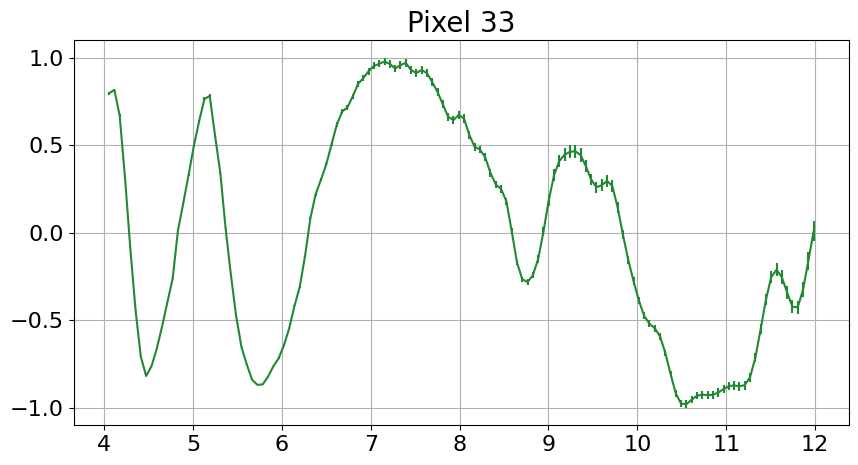

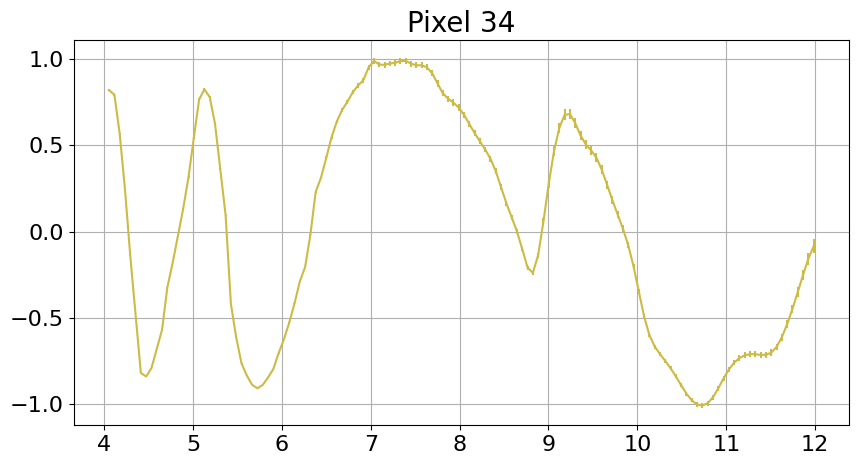

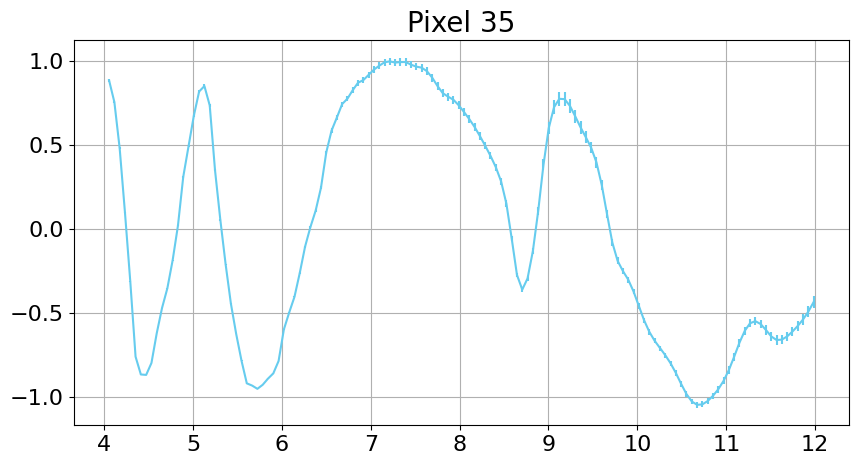

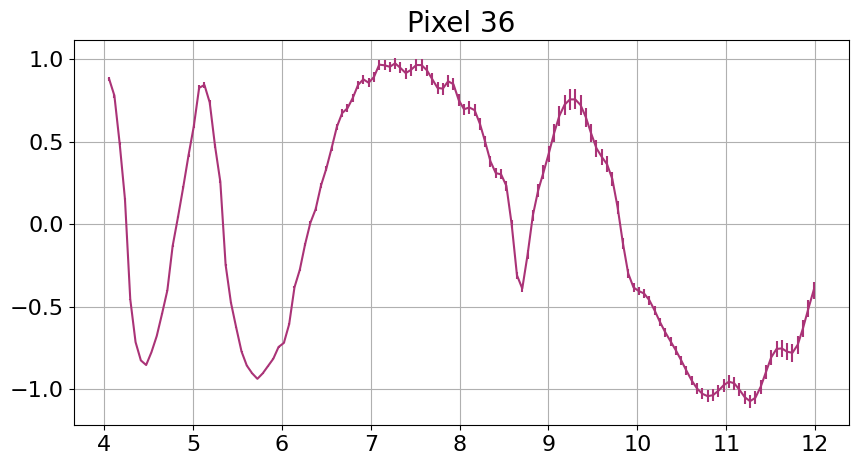

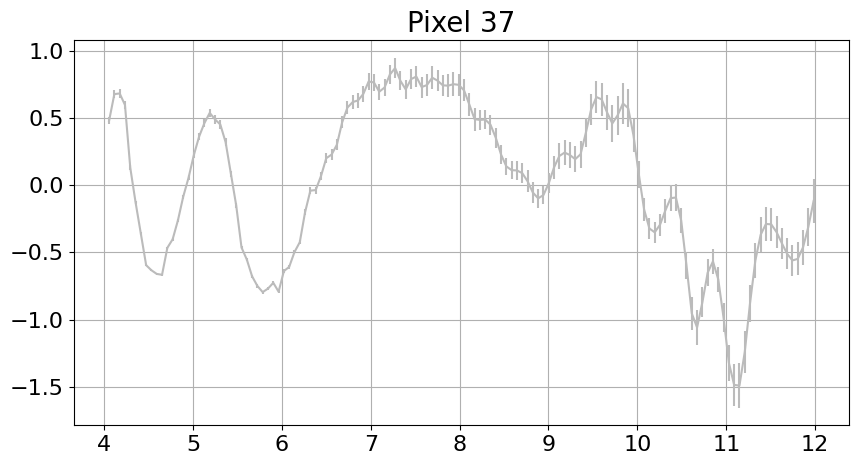

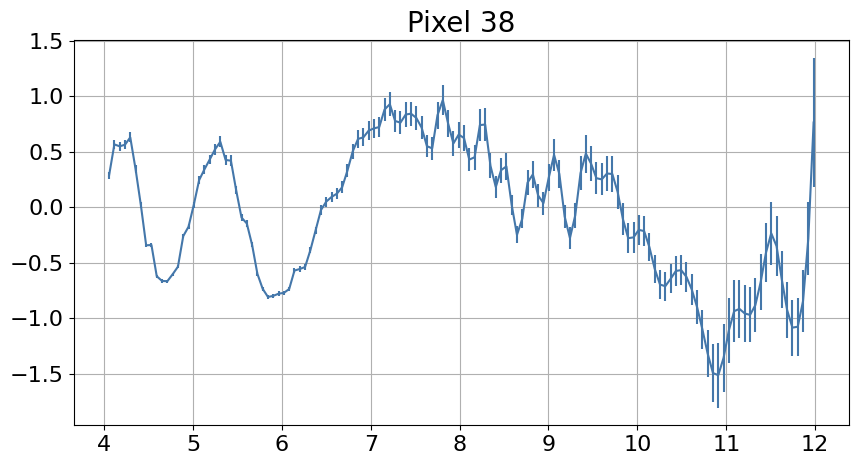

In [147]:
if True:
    fig,axs = prepare_plot()
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_pol,para_pol_errs)):
        axs[0].plot(qlam_para,data,color=f'C{indx}',label=f'{pixel}')
        axs[0].errorbar(qlam_para,data,yerr=error,linestyle='',color=f'C{indx}')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

if True:
    for indx,(pixel,data,error) in enumerate(zip(PIXELS,para_pol,para_pol_errs)):
        fig,axs = prepare_plot({'title':[f'Pixel {pixel}']})
        axs[0].plot(qlam_blank,data,color=f'C{indx}')
        axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
        plt.show()

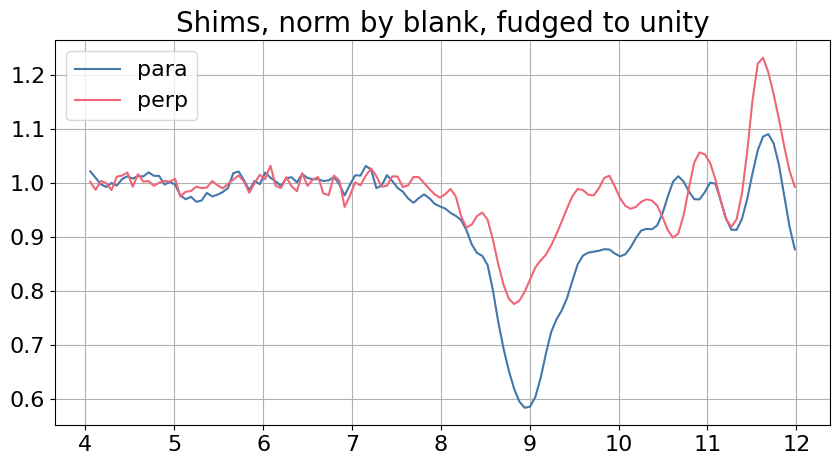

In [155]:
assert para_shim.shape == blank_shim.shape, 'Sample and blank must have the same shape!'
para_shim_norm = np.sum(para_shim/blank_shim,axis=0)
#perp_shim_norm_errors = np.sqrt(perp_shim**2 + blank_shim**2)

if True:
    temp,_ = curve_fit(f:=lambda x,a,b: a*x + b,qlam_blank[:50],para_shim_norm[:50])
    para_shim_norm = para_shim_norm/f(qlam_blank,*temp)

fig,axs = prepare_plot({'title':['Shims, norm by blank, fudged to unity']})
axs[0].plot(qlam_blank,para_shim_norm,label='para')
axs[0].plot(qlam_blank,perp_shim_norm,label='perp')
#axs[0].errorbar(qlam_blank,data,yerr=error,linestyle='',color=f'C{indx}')
#axs[0].plot(qlam_blank[:50],f(qlam_blank[:50],*temp))
plt.legend()
plt.show()

In [ ]:
LAMS_para_p35,Up_para_p35,Eup_para_p35,pname = load_data_2D(r"para_p35\\up.txt")
_,Dn_para_p35,Edn_para_p35,_ = load_data_2D(r"para_p35\\dn.txt")

_ = get_center(Up_para_p35,Dn_para_p35,pname)  #checking alignment

POL_PLOT_PARMS = DEFAULT_POL_PLOT_PARMS|{'title':'Para, no grating','extent':(LAMBDAS[0],LAMBDAS[-1],PIXELS[0],PIXELS[-1])}
SHIM_PLOT_PARMS = POL_PLOT_PARMS|{'title':'Para, no grating, shim','vals':(None,None),'log vals':(-8,-4)}

LAMS_para_p35,Up_para_p35,Eup_para_p35,Dn_para_p35,Edn_para_p35 = trim_arr((LAMS_para_p35,Up_para_p35,Eup_para_p35,\
                                                                           Dn_para_p35,Edn_para_p35),[(3.,12.)])
Up_para_p35 = Up_para_p35[EDGES[0]:EDGES[-1],:]  #uses global EDGES tuple
Eup_para_p35 = Eup_para_p35[EDGES[0]:EDGES[-1],:]
Dn_para_p35 = Dn_para_p35[EDGES[0]:EDGES[-1],:]
Edn_para_p35 = Edn_para_p35[EDGES[0]:EDGES[-1],:]

plot_2D(Up_para_p35,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw up'})
plot_2D(Dn_para_p35,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw down'})
plot_2D(Up_para_p35+Dn_para_p35,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw shim'})

para_p35_lam,Up_para_p35,Up_para_p35_err = get_constant_Q(Up_para_p35,Eup_para_p35,LAMBDAS,th0=.35,trim=(1,-1),lims=(None,None),\
                                                          show_all=False,show_all_intrp=False,show_final_intrp=False,show_sum=True)
_,Dn_para_p35,Dn_para_p35_err = get_constant_Q(Dn_para_p35,Edn_para_p35,LAMBDAS,th0=.35,trim=(1,-1),lims=(None,None),\
                                               show_all=False,show_all_intrp=False,show_final_intrp=False,show_sum=True)

Shim_para_p35,STD_para_p35 = get_shim(Up_para_p35,Dn_para_p35,plot_parms=SHIM_PLOT_PARMS)

Pol_para_p35,_ = get_pol(Up_para_p35,Dn_para_p35)
Pol_para_p35 = Pol_para_p35/fitted_q[1:-1]  #normalize by P0

plot_2D(Pol_para_p35,plot_parms=POL_PLOT_PARMS|{'title':'Para, no grating, pol'})

In [ ]:
Para_p35_shim_s = np.sum(Shim_para_p35[1:,:],axis=0)/np.sum(Shim_blank[1:,:],axis=0)
Para_p35_pol_m = np.mean(Pol_para_p35[1:,:],axis=0)

plt.figure(figsize=(11,4))
plt.title('Pol (-) and shim (--), no grating')
if False:
    for indx,(p,s,sb) in enumerate(zip(Pol_para_p35[1:,:],Shim_para_p35[1:,:],Shim_blank[1:,:])):
        plt.plot(para_p35_lam,p,label=f'{indx}',color=f'C{indx}')
        plt.plot(para_p35_lam,s/sb,'--',color=f'C{indx}')
plt.plot(para_p35_lam,Para_p35_pol_m,color='black',label='av')
plt.plot(para_p35_lam,Para_p35_shim_s,'--',color='black')
plt.grid()
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim((-1.1,1.1))
plt.show()

### Sample parallel, grating before (to do)
***

In [ ]:
LAMS_para_p35_before,Up_para_p35_before,Eup_para_p35_before,pname = load_data_2D(r"para_p35_before\\up.txt")
_,Dn_para_p35_before,Edn_para_p35_before,_ = load_data_2D(r"para_p35_before\\dn.txt")

_ = get_center(Up_para_p35_before,Dn_para_p35_before,pname)  #checking alignment

POL_PLOT_PARMS = DEFAULT_POL_PLOT_PARMS|{'title':'Para, grating before','extent':(LAMBDAS[0],LAMBDAS[-1],PIXELS[0],PIXELS[-1])}
SHIM_PLOT_PARMS = POL_PLOT_PARMS|{'title':'Para, grating before, shim','vals':(None,None),'log vals':(-8,-4)}

LAMS_para_p35_before,Up_para_p35_before,Eup_para_p35_before,Dn_para_p35_before,Edn_para_p35_before = trim_arr((LAMS_para_p35_before,Up_para_p35_before,Eup_para_p35_before,Dn_para_p35_before,Edn_para_p35_before),[(3.,12.)])

Up_para_p35_before = Up_para_p35_before[EDGES[0]:EDGES[-1],:]  #uses global EDGES tuple
Eup_para_p35_before = Eup_para_p35_before[EDGES[0]:EDGES[-1],:]
Dn_para_p35_before = Dn_para_p35_before[EDGES[0]:EDGES[-1],:]
Edn_para_p35_before = Edn_para_p35_before[EDGES[0]:EDGES[-1],:]

plot_2D(Up_para_p35_before,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw up'})
plot_2D(Dn_para_p35_before,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw down'})
plot_2D(Up_para_p35_before+Dn_para_p35_before,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw shim'})

plot_2D(no_q_pol_before:=get_pol(Up_para_p35_before,Dn_para_p35_before)[0],plot_parms=POL_PLOT_PARMS|{'title':'Para, grating before, pol pre-q binning'})

para_p35_before_lam,Up_para_p35_before,Up_para_p35_err_before = get_constant_Q(Up_para_p35_before,Eup_para_p35_before,LAMBDAS,th0=.35,trim=(1,-1),lims=(None,None),\
                                                                               show_all=False,show_all_intrp=False,show_final_intrp=False,show_sum=True)
_,Dn_para_p35_before,Dn_para_p35_err_before = get_constant_Q(Dn_para_p35_before,Edn_para_p35_before,LAMBDAS,th0=.35,trim=(1,-1),lims=(None,None),\
                                                             show_all=False,show_all_intrp=False,show_final_intrp=False,show_sum=True)

Shim_para_p35_before,STD_para_p35_before = get_shim(Up_para_p35_before,Dn_para_p35_before,plot_parms=SHIM_PLOT_PARMS)

Pol_para_p35_before,_ = get_pol(Up_para_p35_before,Dn_para_p35_before)
Pol_para_p35_before = Pol_para_p35_before/fitted_q[1:-1]  #normalize by P0

plot_2D(Pol_para_p35_before,plot_parms=POL_PLOT_PARMS|{'title':'Para, grating before, pol'})

In [ ]:
Para_p35_before_shim_s = np.sum(Shim_para_p35_before[1:,:],axis=0)/np.sum(Shim_blank[1:,:],axis=0)
Para_p35_before_pol_m = np.mean(Pol_para_p35_before[1:,:],axis=0)

plt.figure(figsize=(11,4))
plt.title('Pol (-) and shim (--), grating before')
if False:
    for indx,(p,s,sb) in enumerate(zip(Pol_para_p35_before[1:,:],Shim_para_p35_before[1:,:],Shim_blank[1:,:])):
        plt.plot(para_p35_before_lam,p,label=f'{indx}',color=f'C{indx}')
        plt.plot(para_p35_before_lam,s/sb,'--',color=f'C{indx}')
plt.plot(para_p35_lam,Para_p35_before_pol_m,color='black',label='av')
plt.plot(para_p35_lam,Para_p35_before_shim_s,'--',color='black')
plt.grid()
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim((-1.1,1.1))
plt.show()

##### Rob's code comparison:

Notice that the blue (data directly from the Mantid reduction script) and yellow (manually averaged over the entire detector from the 2D data) lines are equivalent. Therefore, the Mantid reduction is summing over the entire detector, and not just the middle 7 pixels as we previously thought.

This also shows that we are getting a noticeable scattering contribution from the grating, even before the sample.

In [ ]:
x_av,y_av,_ = load_data(r"para_p35_before\\pol_av.txt")  #Rob's method here
x_av,y_av = trim_arr((x_av,y_av),[(3.,12.)])
rob = y_av/np.mean(fitted,axis=0)

lams,up,_,_ = load_data_2D(r"para_p35_before\\up.txt")
_,dn,_,_ = load_data_2D(r"para_p35_before\\dn.txt")
lams,up,dn = trim_arr((lams,up,dn),[(3.,12.)])
up = up[EDGES[0]:EDGES[-1],:]
dn = dn[EDGES[0]:EDGES[-1],:]

Para_p35_before_summed_n = compare_1d(up,dn,rob,lams,fitted)

##### Standard deviation check:

Seems like there is some spreading, so I need to check the expanded shim.

In [ ]:
plt.figure(figsize=(10,4)) #para_p35_lam
plt.title('Grating before shim')
for pix,s in enumerate(Shim_para_p35_before[1:,:]/Shim_blank[1:,:]):
    plt.plot(para_p35_lam,s,label=f'Pix {pix}')
plt.plot(para_p35_lam,Para_p35_before_shim_s,label='sum',color='black')
plt.ylim((0,1.1))
plt.xlabel('Wavelength')
plt.grid()
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(10,4))
plt.title('Grating before shim standard deviation')
plt.xlabel('Wavelength')
plt.plot(para_p35_before_lam,STD_para_p35_before,'.-')
plt.grid()
plt.show()

para_sigs,para_errs,tests = do_sig_fit(Shim_para_p35_before,para_p35_before_lam,tests=[250,260],use_shim=True)

plt.figure(figsize=(10,4))
plt.title('Grating before standard deviations')
plt.plot(para_p35_before_lam,para_sigs,'.',color='C0',label='fitted')
plt.plot(para_p35_before_lam,STD_para_p35_before,'.-',color='C1',label='calc')
plt.errorbar(para_p35_before_lam,para_sigs,yerr=para_errs,color='C0',ls='')
plt.axvline(x=para_p35_before_lam[tests[0]],ls='--',color='black')
plt.axvline(x=para_p35_before_lam[tests[-1]],ls='--',color='black')
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Wavelength')
plt.ylim((0.,2.))
plt.grid()
plt.show()

In [ ]:
_,up_ng,_,pname = load_data_2D(r"para_p35\\up.txt")
_,dn_ng,_,_ = load_data_2D(r"para_p35\\dn.txt")

lam,up,_,pname = load_data_2D(r"para_p35_before\\up.txt")
_,dn,_,_ = load_data_2D(r"para_p35_before\\dn.txt")

temp_cut = [25,45]

lam,up,dn,up_ng,dn_ng = trim_arr((lam,up,dn,up_ng,dn_ng),[(3.,12.)])
lam,up,dn,up_ng,dn_ng = [k[temp_cut[0]:temp_cut[-1],:] for k in [lam,up,dn,up_ng,dn_ng]]

SHIM_PLOT_PARMS = POL_PLOT_PARMS|{'title':'Para, no grating, shim','vals':(None,None),'log vals':(-10,-4),\
                                 'extent':(LAMBDAS[0],LAMBDAS[-1],temp_cut[0],temp_cut[-1]),'aspect':.1}
_ = get_shim(up_ng,dn_ng,plot_parms=SHIM_PLOT_PARMS)

SHIM_PLOT_PARMS = SHIM_PLOT_PARMS|{'title':'Para, grating before, shim'}
_ = get_shim(up,dn,plot_parms=SHIM_PLOT_PARMS)

### Sample parallel, grating after (to do)

In [ ]:
LAMS_para_p35_after,Up_para_p35_after,Eup_para_p35_after,pname = load_data_2D(r"para_p35_after\\up.txt")
_,Dn_para_p35_after,Edn_para_p35_after,_ = load_data_2D(r"para_p35_after\\dn.txt")

_ = get_center(Up_para_p35_after,Dn_para_p35_after,pname)  #checking alignment

POL_PLOT_PARMS = DEFAULT_POL_PLOT_PARMS|{'title':'Para, grating after','extent':(LAMBDAS[0],LAMBDAS[-1],PIXELS[0],PIXELS[-1])}
SHIM_PLOT_PARMS = POL_PLOT_PARMS|{'title':'Para, grating after, shim','vals':(None,None),'log vals':(-8,-4)}

LAMS_para_p35_after,Up_para_p35_after,Eup_para_p35_after,Dn_para_p35_after,Edn_para_p35_after = trim_arr((LAMS_para_p35_after,Up_para_p35_after,Eup_para_p35_after,Dn_para_p35_after,Edn_para_p35_after),[(3.,12.)])

Up_para_p35_after = Up_para_p35_after[EDGES[0]:EDGES[-1],:]  #uses global EDGES tuple
Eup_para_p35_after = Eup_para_p35_after[EDGES[0]:EDGES[-1],:]
Dn_para_p35_after = Dn_para_p35_after[EDGES[0]:EDGES[-1],:]
Edn_para_p35_after = Edn_para_p35_after[EDGES[0]:EDGES[-1],:]

plot_2D(Up_para_p35_after,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw up'})
plot_2D(Dn_para_p35_after,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw down'})
plot_2D(Up_para_p35_after+Dn_para_p35_after,plot_parms=SHIM_PLOT_PARMS|{'title':'Raw shim'})

plot_2D(no_q_pol_after:=get_pol(Up_para_p35_after,Dn_para_p35_after)[0],plot_parms=POL_PLOT_PARMS|{'title':'Para, grating after, pol pre-q binning'})

para_p35_after_lam,Up_para_p35_after,Up_para_p35_err_after = get_constant_Q(Up_para_p35_after,Eup_para_p35_after,LAMBDAS,th0=.35,trim=(1,-1),lims=(None,None),\
                                                                               show_all=False,show_all_intrp=False,show_final_intrp=False,show_sum=True)
_,Dn_para_p35_after,Dn_para_p35_err_after = get_constant_Q(Dn_para_p35_after,Edn_para_p35_after,LAMBDAS,th0=.35,trim=(1,-1),lims=(None,None),\
                                                             show_all=False,show_all_intrp=False,show_final_intrp=False,show_sum=True)

Shim_para_p35_after,STD_para_p35_after = get_shim(Up_para_p35_after,Dn_para_p35_after,plot_parms=SHIM_PLOT_PARMS)

Pol_para_p35_after,_ = get_pol(Up_para_p35_after,Dn_para_p35_after)
Pol_para_p35_after = Pol_para_p35_after/fitted_q[1:-1]  #normalize by P0

plot_2D(Pol_para_p35_after,plot_parms=POL_PLOT_PARMS|{'title':'Para, grating after, pol'})

In [ ]:
Para_p35_after_shim_s = np.sum(Shim_para_p35_after[1:,:],axis=0)/np.sum(Shim_blank[1:,:],axis=0)
Para_p35_after_pol_m = np.mean(Pol_para_p35_after[1:,:],axis=0)

plt.figure(figsize=(11,4))
plt.title('Pol (-) and shim (--), grating after')
if True:
    for indx,(p,s,sb) in enumerate(zip(Pol_para_p35_after[1:,:],Shim_para_p35_after[1:,:],Shim_blank[1:,:])):
        plt.plot(para_p35_after_lam,p,label=f'{indx}',color=f'C{indx}')
        plt.plot(para_p35_after_lam,s/sb,'--',color=f'C{indx}')
plt.plot(para_p35_lam,Para_p35_after_pol_m,color='black',label='av')
plt.plot(para_p35_lam,Para_p35_after_shim_s,'--',color='black')
plt.grid()
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim((-1.1,1.1))
plt.show()

In [ ]:
plt.figure(figsize=(10,4)) #para_p35_lam
plt.title('Grating after shim')
for pix,s in enumerate(Shim_para_p35_after[1:,:]/Shim_blank[1:,:]):
    plt.plot(para_p35_lam,s,label=f'Pix {pix}')
plt.plot(para_p35_lam,Para_p35_after_shim_s,label='sum',color='black')
plt.ylim((0,1.1))
plt.xlabel('Wavelength')
plt.grid()
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(10,4))
plt.title('Grating after shim standard deviation')
plt.xlabel('Wavelength')
plt.plot(para_p35_after_lam,STD_para_p35_after,'.-')
plt.grid()
plt.show()

para_sigs,para_errs,tests = do_sig_fit(Shim_para_p35_after,para_p35_after_lam,tests=[250,260],use_shim=True)

plt.figure(figsize=(10,4))
plt.title('Grating after standard deviations')
plt.plot(para_p35_after_lam,para_sigs,'.',color='C0',label='fitted')
plt.plot(para_p35_after_lam,STD_para_p35_after,'.-',color='C1',label='calc')
plt.errorbar(para_p35_after_lam,para_sigs,yerr=para_errs,color='C0',ls='')
plt.axvline(x=para_p35_after_lam[tests[0]],ls='--',color='black')
plt.axvline(x=para_p35_after_lam[tests[-1]],ls='--',color='black')
ax = plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Wavelength')
plt.ylim((0.,2.))
plt.grid()
plt.show()

##### The spread due to Bragg scattering with the grating behind the GH sample is much more apparent, as expected.

In [ ]:
_,up_ng,_,pname = load_data_2D(r"para_p35\\up.txt")
_,dn_ng,_,_ = load_data_2D(r"para_p35\\dn.txt")

lam,up,_,_ = load_data_2D(r"para_p35_before\\up.txt")
_,dn,_,_ = load_data_2D(r"para_p35_before\\dn.txt")

lam,up_af,_,_ = load_data_2D(r"para_p35_after\\up.txt")
_,dn_af,_,_ = load_data_2D(r"para_p35_after\\dn.txt")

temp_cut = [25,45]

lam,up,dn,up_ng,dn_ng,up_af,dn_af = trim_arr((lam,up,dn,up_ng,dn_ng,up_af,dn_af),[(3.,12.)])
lam,up,dn,up_ng,dn_ng,up_af,dn_af = [k[temp_cut[0]:temp_cut[-1],:] for k in [lam,up,dn,up_ng,dn_ng,up_af,dn_af]]

SHIM_PLOT_PARMS = POL_PLOT_PARMS|{'title':'Para, no grating, shim','vals':(None,None),'log vals':(-10,-4),\
                                 'extent':(LAMBDAS[0],LAMBDAS[-1],temp_cut[0],temp_cut[-1]),'aspect':.1}
_ = get_shim(up_ng,dn_ng,plot_parms=SHIM_PLOT_PARMS)

SHIM_PLOT_PARMS = SHIM_PLOT_PARMS|{'title':'Para, grating before, shim'}
_ = get_shim(up,dn,plot_parms=SHIM_PLOT_PARMS)

SHIM_PLOT_PARMS = SHIM_PLOT_PARMS|{'title':'Para, grating after, shim'}
_ = get_shim(up_af,dn_af,plot_parms=SHIM_PLOT_PARMS)

***
### 0.4 degree data (To do)

### Comparisons between the data sets:
***

When the data are binned with consant Q, the difference between the peaks with and without the additional grating disappear.

##### Entire detector shim comparison:

In [ ]:
_,up_ng,_,pname = load_data_2D(r"para_p35\\up.txt")
_,dn_ng,_,_ = load_data_2D(r"para_p35\\dn.txt")

lam,up,_,_ = load_data_2D(r"para_p35_before\\up.txt")
_,dn,_,_ = load_data_2D(r"para_p35_before\\dn.txt")

lam,up_af,_,_ = load_data_2D(r"para_p35_after\\up.txt")
_,dn_af,_,_ = load_data_2D(r"para_p35_after\\dn.txt")

temp_cut = [25,45]

lam,up,dn,up_ng,dn_ng,up_af,dn_af = trim_arr((lam,up,dn,up_ng,dn_ng,up_af,dn_af),[(3.,12.)])
lam,up,dn,up_ng,dn_ng,up_af,dn_af = [k[temp_cut[0]:temp_cut[-1],:] for k in [lam,up,dn,up_ng,dn_ng,up_af,dn_af]]

SHIM_PLOT_PARMS = POL_PLOT_PARMS|{'title':'Para, no grating, shim','vals':(None,None),'log vals':(-10,-4),\
                                 'extent':(LAMBDAS[0],LAMBDAS[-1],temp_cut[0],temp_cut[-1]),'aspect':.085}
_ = get_shim(up_ng,dn_ng,plot_parms=SHIM_PLOT_PARMS)

SHIM_PLOT_PARMS = SHIM_PLOT_PARMS|{'title':'Para, grating before, shim'}
_ = get_shim(up,dn,plot_parms=SHIM_PLOT_PARMS)

SHIM_PLOT_PARMS = SHIM_PLOT_PARMS|{'title':'Para, grating after, shim'}
_ = get_shim(up_af,dn_af,plot_parms=SHIM_PLOT_PARMS)

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Q-corrected total intensities')
plt.plot(para_p35_after_lam,Para_p35_shim_s,label='No grating')  #clean up this x-axis name
plt.plot(para_p35_after_lam,Para_p35_before_shim_s,label='Grating before')
plt.plot(para_p35_after_lam,Para_p35_after_shim_s,label='Grating after')
plt.legend()
plt.grid()
plt.ylabel('Normalized shim')
plt.xlabel('Wavelength')
plt.ylim((0,1))
plt.show()

bs_trim = range(5,len(para_p35_after_lam)-15)
plt.figure(figsize=(10,4))
plt.title('Q-corrected standard deviations')
plt.plot(para_p35_after_lam[bs_trim],STD_para_p35[bs_trim],'.-',label='No grating')
plt.plot(para_p35_after_lam[bs_trim],STD_para_p35_before[bs_trim],'.-',label='Grating before')
plt.plot(para_p35_after_lam[bs_trim],STD_para_p35_after[bs_trim],'.-',label='Grating after')
plt.legend()
plt.grid()
plt.ylabel('Stnd dev')
plt.xlabel('Wavelength')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Q-corrected total intensities, central pixel')
plt.plot(para_p35_after_lam,Shim_para_p35[2,:]/Shim_blank[2,:],label='No grating')  #clean up this x-axis name
plt.plot(para_p35_after_lam,Shim_para_p35_before[2,:]/Shim_blank[2,:],label='Grating before')
plt.plot(para_p35_after_lam,Shim_para_p35_after[2,:]/Shim_blank[2,:],label='Grating after')
plt.legend()
plt.grid()
plt.ylabel('Normalized shim')
plt.xlabel('Wavelength')
plt.ylim((0,1.1))
plt.show()

##### Polarization comparison:

In [ ]:
plot_2D(Pol_para_p35,plot_parms=POL_PLOT_PARMS|{'title':'Para, no grating, pol'})
plot_2D(Pol_para_p35_before,plot_parms=POL_PLOT_PARMS|{'title':'Para, grating before, pol'})
plot_2D(Pol_para_p35_after,plot_parms=POL_PLOT_PARMS|{'title':'Para, grating after, pol'})

plot_2D(no_q_pol_before,plot_parms=POL_PLOT_PARMS|{'title':'Para, grating before, pol, no q-binning'})
plot_2D(no_q_pol_after,plot_parms=POL_PLOT_PARMS|{'title':'Para, grating after, pol, no q-binning'})

In [ ]:
plt.figure(figsize=(10,4))
plt.title('Q-corrected average polarizations')
plt.plot(para_p35_after_lam,Para_p35_pol_m,label='No grating')  #clean up this x-axis name
plt.plot(para_p35_after_lam,Para_p35_before_pol_m,label='Grating before')
plt.plot(para_p35_after_lam,Para_p35_after_pol_m,label='Grating after')
plt.ylabel('Normalized pol')
plt.xlabel('Wavelength')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.title('Q-corrected polarizations, central pixel')
plt.plot(para_p35_after_lam,Pol_para_p35[2,:],label='No grating')  #clean up this x-axis name
plt.plot(para_p35_after_lam,Pol_para_p35_before[2,:],label='Grating before')
plt.plot(para_p35_after_lam,Pol_para_p35_after[2,:],label='Grating after')
plt.ylabel('Normalized pol')
plt.xlabel('Wavelength')
plt.legend()
plt.grid()
plt.show()

##### Other comparions:

***
### Other calculations: